## Índice

### 1. Introducción
- 1.1. Contexto del problema
- 1.2. Objetivo de negocio
- 1.3. Pregunta de investigación
- 1.4. Definición de la variable objetivo
- 1.5. Momento de predicción 


### 2. Carga de Datos y Preparación Inicial
- 2.1. Librerias
- 2.2. Carga de dataset
- 2.3. Inspección inicial (shape, columnas, tipos)
- 2.4. Estandarización de tipos (fechas, numéricas, categóricas)


### 3. Construcción del Target y Cohortes
- 3.1. Cálculo de `lead_time_total_horas`
- 3.2. Cálculo de `cycle_time_horas` (referencia interna)
- 3.3. Análisis de filas excluidas y sesgo potencial


### 4. Auditoría de Calidad de Datos
- 4.1. Coherencia temporal (`FechaIngreso ≤ FechaInicio ≤ FechaFin`)
- 4.2. Rango del target (detección de tiempos negativos o irreales)
- 4.3. Identificación de outliers extremos y decisiones (mantener / winsorizar / excluir)


### 5. Análisis de Valores Faltantes (Missingness)
- 5.1. Tabla general de valores faltantes por columna
- 5.2. Visualización Top-N columnas con mayores faltantes
- 5.3. Patrones de ausencia por grupos (`Ubicacion`, `TipoMaterialId`, etc.)
- 5.4. Coausencia entre variables (correlación de nulos)
- 5.5. Estrategia de manejo 


### 6. Diccionario y Agrupación de Variables
- 6.1. Agrupación y descripción de variables
- 6.2. Diccionario de datos


### 7. Análisis de Outliers Multivariado
- 7.1. Detección con Isolation Forest
- 7.2. Visualización de anomalías


### 8. Análisis Avanzado (Correlación y Estacionalidad)
- 8.1. Correlación Pearson vs Spearman
- 8.2. Análisis de estacionalidad temporal
- 8.3. Importancia de variables (Random Forest)


### 9. División de Entrenamiento / Validación Temporal
- 9.1. Corte temporal por `FechaIngreso`
- 9.2. Train = histórico, Test = reciente 
- 9.3. Validación del tamaño de cada split


### 10. Conclusiones del EDA
- 10.1. Variables más relevantes
- 10.2. Principales factores que explican el tiempo de producción
- 10.3. Problemas de calidad detectados y decisiones tomadas
- 10.4. Implicaciones para el modelado predictivo


### 11. Próximos Pasos
- 11.1. Selección final de features
- 11.2. Modelos a evaluar
- 11.3. Métricas y estrategias de validación


---

## 1. Introducción

### 1.1 Contexto del problema

La fábrica de confección registra, para cada pedido y sus detalles, información operativa (materiales, diseño, máquina, operario, tiempos parciales y lecturas de proceso) junto con fechas de ingreso, inicio y fin de producción. En la operación actual, la promesa de entrega se realiza con reglas empíricas y conocimiento tácito del personal de planta, lo que genera variabilidad en los plazos comprometidos, atrasos no anticipados y sobrecostos por reprocesos o reprogramaciones.

El objetivo de este estudio es caracterizar rigurosamente los tiempos de flujo del pedido —en particular el **tiempo total desde ingreso hasta cierre, `lead_time_total_horas`**— para identificar patrones, fuentes de variabilidad y factores determinantes, y así sentar las bases de un modelo predictivo que permita **prometer fechas con mayor precisión y gestionar capacidad de forma proactiva**.

**Alcance**
- **Unidad de análisis**: pedido/detalle de pedido.
- **Periodo de estudio**: histórico disponible en las fuentes (especificar rango de fechas).
- **Variable objetivo**: `lead_time_total_horas = FechaFin − FechaIngreso` (en horas) para pedidos cerrados.
- **Momento de predicción**: en **`FechaIngreso`** al crear el pedido, de cara a promesa comercial.

**Relevancia**
- **Promesa de entrega**: mejora del SLA percibido por clientes y reducción de penalizaciones.
- **Planificación y capacidad**: priorización de órdenes y asignación de recursos (máquinas/turnos) con base en riesgo de atraso.
- **Mejora continua**: identificación de cuellos de botella (por planta, material, diseño) y cuantificación de impacto.

**Stakeholders**
- **Comercial/Customer Success**: promesa y seguimiento de fecha comprometida.
- **Planeación y Producción**: secuenciación, asignación de máquinas/operarios y control de WIP.
- **Calidad**: análisis de reprocesos y su efecto en tiempo total.
- **Dirección**: indicadores de servicio y eficiencia operativa.

**Supuestos y restricciones**
- **Integridad temporal**: se asume `FechaIngreso ≤ FechaInicio ≤ FechaFin`; las violaciones se auditarán y documentarán.
- **Mediciones homogéneas**: unidades consistentes (minutos/horas) y codificación estable de categóricas (materiales, diseños, ubicaciones). Se normalizarán si hay inconsistencias.
- **Disponibilidad de datos**: no todos los campos están completos; se aplicará una estrategia documentada para valores faltantes sin introducir fuga de información.
- **No fuga de información**: en el escenario de predicción al ingreso, no se emplearán variables que solo existen después del inicio/fin de producción.

**Decisiones metodológicas clave**
- Análisis primario sobre **pedidos cerrados** para estimar y modelar `lead_time_total_horas`.
- Cohortes y splits **temporales** para evaluación (train: histórico; test: más reciente).
- Métrica de referencia de negocio: **MAE en horas** frente a baselines (medianas globales/por grupo).
- En etapas posteriores, extensión a **tiempo restante** durante la producción (no cubierto en esta sección).

**Resultado esperado de esta etapa**
- Marco conceptual y operativo del problema claramente definido.
- Criterios de inclusión/exclusión y supuestos explícitos para todo el EDA.
- Lista de variables candidatas y riesgos de sesgo/fuga que guiarán las siguientes secciones.


### 1.2 Objetivo de negocio

**Objetivo principal**  
Mejorar la precisión de la promesa de entrega mediante la estimación del **tiempo total desde ingreso hasta cierre** del pedido (**`lead_time_total_horas`**), de forma **anticipada** (en `FechaIngreso`), para soportar decisiones comerciales y de planificación.

**Objetivos específicos**
1. **Pronóstico confiable del lead time** al momento de creación del pedido, con error absoluto medio (MAE) ≤ *X* horas (definir con stakeholders) y reducción ≥ *Y*% respecto al baseline actual (mediana histórica).
2. **Segmentación operativa**: identificar materiales, diseños y ubicaciones con mayores tiempos y variabilidad (brechas en P50/P80), para priorizar acciones de mejora.
3. **Gestión de riesgo**: proveer percentiles (P50/P80/P95) por pedido para soportar promesas conservadoras cuando sea necesario.
4. **Trazabilidad**: estandarizar el flujo de datos y las reglas de negocio (cohortes, exclusiones, manejo de nulos) para replicabilidad y auditoría.

**Indicadores (KPIs) de éxito**
- **Precisión de promesa**: MAE (horas) y MAPE (%) del pronóstico vs. `lead_time_total_horas` en conjunto de prueba **temporal**.
- **Confiabilidad**: cobertura empírica de los intervalos P50/P80 (ej., P80 cubre ~80% de los casos en test).
- **Estabilidad**: degradación ≤ *Z*% del error al comparar dos cortes temporales consecutivos (drift control).
- **Utilidad operativa**: reducción de atrasos (SLA incumplidos) y reprogramaciones (medido trimestralmente).

**Alcance (qué incluye)**
- Construcción y validación del objetivo `lead_time_total_horas` para **pedidos cerrados**.
- Análisis exploratorio y establecimiento de baselines de negocio sin ML.
- Identificación de variables predictoras **disponibles al crear el pedido** (sin fuga).
- Partición de entrenamiento/prueba por **corte temporal** (no aleatoria).

**Fuera de alcance (qué no incluye en esta fase)**
- Modelos en línea de **tiempo restante** (remaining time) durante la ejecución.
- Optimización de secuenciación en planta o simulaciones de capacidad.
- Integración en sistemas productivos (API/UX); aquí se enfoca el EDA y bases para modelado.

**Restricciones y supuestos**
- **Disponibilidad de datos**: se trabaja con el histórico vigente; pedidos sin `FechaFin` quedan fuera del cómputo del objetivo (pueden analizarse aparte).
- **Coherencia temporal**: se reportarán y tratarán inconsistencias (`FechaFin < FechaInicio`, etc.).
- **Unidades**: todas las duraciones se homologarán a **horas**.
- **Granularidad**: análisis a nivel detalle de pedido; agregación a nivel pedido cuando aplique (máx. `FechaFin`, mín. `FechaIngreso`).

**Criterios de aceptación**
- Documento EDA con: definiciones, cohortes, reglas de limpieza, análisis de nulos/outliers, descriptivas, brechas por grupos y baselines cuantificados.
- Repositorio reproducible con scripts/notebook y datasets derivados (estándar, cohortes, splits temporales).
- Métrica base (MAE) del baseline y objetivo cuantificado de mejora acordado con negocio.


### 1.3 Pregunta de investigación

**Pregunta central**  
¿Con qué precisión es posible **estimar el tiempo total de producción** de un pedido en una fábrica de confección —definido como `lead_time_total_horas = FechaFin − FechaIngreso`— **en el momento de su creación** (`FechaIngreso`), utilizando únicamente variables conocidas en ese instante (tamaño, materialidad, complejidad y contexto operativo)?

**Subpreguntas específicas**
1. **Determinantes**: ¿Qué factores (tamaño del pedido, complejidad del diseño, materialidad, ubicación/línea) explican mayor variabilidad del `lead_time_total_horas`?
2. **Capas de variabilidad**: ¿Cuánta variación se atribuye a diferencias **entre** ubicaciones/planta y cuánta a diferencias **dentro** de cada ubicación (por tipo de material o diseño)?
3. **Robustez temporal**: ¿Se mantienen estables las relaciones identificadas al evaluar en un **conjunto de prueba temporal** (histórico → reciente)?
4. **Promesa conservadora**: ¿Qué tan bien calibrados están los cuantiles operativos (P50, P80, P95) para soportar promesas de entrega conservadoras?
5. **Impacto de la calidad de datos**: ¿Cómo afectan a la precisión los **valores faltantes**, outliers y posibles inconsistencias temporales, y qué estrategias de tratamiento son más efectivas?

**Hipótesis operativas (a contrastar en el EDA)**
- **H1 (Complejidad)**: Un mayor nivel de complejidad (e.g., `NumeroApliques`, `Puntadas`, `DisenosTPTG`) se asocia con incrementos monotónicos en `lead_time_total_horas`.
- **H2 (Tamaño)**: El tamaño del pedido (`Cantidad`, `CantidadOrden`) incrementa el `lead_time_total_horas` con **rendimientos decrecientes** a partir de cierto umbral (no linealidad).
- **H3 (Materialidad)**: La materialidad (`TipoMaterialId`, insumos especiales como `Plastico`, `Chenille`) introduce diferencias sistemáticas en medianas y colas (P80/P95) del lead time.
- **H4 (Estacionalidad)**: Variables de calendario derivadas de `FechaIngreso` (mes, día de la semana, hora) explican parte de la variabilidad por efectos de demanda/capacidad.

**Operacionalización y criterios de evaluación**
- **Variable dependiente**: `lead_time_total_horas` (horas), calculada solo para **pedidos cerrados** (`FechaFin` no nula).
- **Variables independientes (disponibles al crear el pedido)**: tamaño/carga (`Cantidad`, `CantidadOrden`, `CantidadProgramada`), complejidad (`NumeroApliques`, `Puntadas`, `DisenosTPTG`), materialidad (`TipoMaterialId`, insumos/flags), producto/variante (`Talla`, `Fondo`, `ColorFondo`, `MaterialPedido`), **calendario** (de `FechaIngreso`), y **Ubicacion`.
- **Métrica principal (descriptiva para promesa)**: MAE (horas) de baselines **sin ML** (mediana global, por `Ubicacion`, por `TipoMaterialId`) como referencia para fases posteriores.
- **Métricas de calibración de cuantiles**: cobertura empírica de P50/P80/P95 en conjunto de prueba temporal.
- **Validez interna**: control de **fuga de información** (exclusión de variables posteriores a `FechaIngreso`, p.ej., `FechaInicio`, `FechaFin`, tiempos de proceso y calidad resultante).

**Supuestos y alcance de la inferencia**
- **Supuesto temporal**: `FechaIngreso ≤ FechaInicio ≤ FechaFin`; inconsistencias serán auditadas y documentadas.
- **Datos faltantes**: el tratamiento (imputación/categorización/exclusión) se definirá por tipo de variable y patrón de ausencia; se realizará análisis de **coausencia**.
- **Generalización**: las conclusiones aplican al período histórico analizado y deberán reevaluarse ante cambios estructurales (turnos, maquinaria, mezcla de productos).

**Resultado esperado de la sección**  
Un marco de investigación claro que delimite la estimación temprana del `lead_time_total_horas`, identifique los factores a evaluar en el EDA y establezca métricas y supuestos para interpretar hallazgos con rigor académico y utilidad operativa.


### 1.4 Definición de la variable objetivo  

**Definición de la variable objetivo (`lead_time_total_horas`)**  
La variable objetivo del estudio corresponde al **tiempo total transcurrido entre el ingreso del pedido y su finalización**, expresado en horas. Esta medida refleja la **duración efectiva del proceso productivo**, incluyendo esperas, secuenciaciones, actividades manuales y tiempos en máquina.

lead_time_total_horas = (FechaFin − FechaIngreso) / 3600

- `FechaIngreso`: fecha y hora en que el pedido entra al sistema productivo.  
- `FechaFin`: fecha y hora en que el pedido se termina y queda disponible como producto completo.  
- **Condición de cálculo**: solo se calcula para **pedidos cerrados** (`FechaFin` no nula). Los pedidos en ejecución pueden analizarse por separado como *pedidos en progreso*.

**Naturaleza interpretativa del objetivo**  
`lead_time_total_horas` captura no solo actividades productivas directas, sino también:
- tiempos de espera entre operaciones,
- diferencias de capacidad por turno/planta,
- variaciones por tipo de producto y material,
- ineficiencias, retrabajos o interrupciones.  
Es, por tanto, una medida **integral** del flujo del pedido a través del sistema productivo.

### 1.5 Momento de predicción

**Momento de predicción (escenario de uso)**  
La predicción se realiza **en el momento en que el pedido es creado**: `FechaIngreso`. Para **evitar fuga de información**, solo se emplearán variables **disponibles ex ante**.

**Variables permitidas en el momento de predicción**
- **Tamaño / carga**: `Cantidad`, `CantidadOrden`, `CantidadProgramada`.
- **Producto / variante**: `Talla`, `Fondo`, `ColorFondo`, `MaterialPedido`.
- **Materialidad**: `TipoMaterialId`, `codigoMaterial`.
- **Complejidad inicial**: `NumeroApliques`, `DisenosTPTG` (si se conocen desde diseño).
- **Ubicación / línea**: `Ubicacion` (y `NombreMaquina` solo si se asigna de inicio).
- **Calendario**: variables derivadas de `FechaIngreso` (`mes`, `día_semana`, `hora_ingreso`).

**Variables prohibidas (posteriores, causarían fuga)**
- **Tiempos de ejecución**: `TiempoMaquina`, `TiempoPulida`, `TiempoQuitarPlastico`, etc.
- **Resultados de calidad**: `CantidadBuena`, `CantidadMala`, `CantidadReprocesada`.
- **Fechas posteriores**: `FechaInicio`, `FechaFin`.

**Implicación metodológica**
1. El pedido ingresa (`FechaIngreso`).
2. Se conocen sus atributos iniciales.
3. Se estima `lead_time_total_horas`.
4. Se define promesa de entrega o priorización operativa.

De esto se desprende que:
- La **división de entrenamiento y prueba** debe ser **temporal** (histórico → reciente).
- La **selección de features** se fundamenta en **disponibilidad temporal**, no en mera correlación.
- La evaluación se realizará **en un conjunto de prueba temporal**, para validar la utilidad operativa.

**Resultado esperado de esta sección**
- `lead_time_total_horas` queda definida con claridad conceptual y operacional.
- Se establece el **punto de predicción** (FechaIngreso) y la **lista explícita de variables elegibles**.
- Se previene la **fuga de información**, asegurando rigor académico y relevancia práctica.


---

## 2. Carga de Datos


### 2.1 Librerias

In [1813]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns
import re
from textwrap import fill,wrap
import itertools
import math



# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Configuración reproducible
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



### 2.2. Carga de dataset

In [1814]:
df = pd.read_csv('data/produccion.csv')
df.head()


C:\Users\Admin\AppData\Local\Temp\ipykernel_5824\1139538576.py:1: DtypeWarning: Columns (18,27,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/produccion.csv')


,Operario,PedidoId,NumeroOrden,MaterialIdOrden,TipoMaterialId,codigoMaterial,CantidadOrden,NombreMaquina,CantidadProgramada,FechaInicio,FechaFin,año,TiempoenMaquina,CantidadBuena,CantidadMala,CantidadReprocesada,MaterialId,Ubicacion,PuntoPlantilla,DisenosTPTG,InterlonId,HiloInferiorId,NumeroApliques,TiempoAlistamiento,TiempoMaquina,TiempoAplique,TiempoPulida,Velocidad,Puntadas,Plastico,MaquinaPlasticoId,TiempoQuitarPlastico,Canutillo,Chenille,Cordon,Presion,Temperatura,Unnamed: 37
0,Edward Dario Pulgarin Paniagua,5912,O11585,1625,28,U53554,241,Bordadora 12,241,2021-06-15 11:21:39.9748690,2021-06-15 17:41:58.7622990,2021,380.00,162,0,0,1625,NaN,1,NaN,NaN,91.00,0.00,NaN,NaN,NaN,NaN,NaN,1735.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Edward Dario Pulgarin Paniagua,5981,O11681,1625,28,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.00,471,0,0,1625,NaN,1,NaN,NaN,91.00,0.00,NaN,NaN,NaN,NaN,NaN,1735.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Edwin Alonso Jaramillo Castaño,5981,O11681,1625,28,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.00,5,0,0,1625,NaN,1,NaN,NaN,91.00,0.00,NaN,NaN,NaN,NaN,NaN,1735.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Francisco Nicolas Parra Acevedo,4225,O8269,1625,28,U53554,10,Bordadora 05,10,2021-03-08 10:38:09.8705291,2021-03-08 11:25:26.7423458,2021,47.00,10,0,0,1625,NaN,1,NaN,NaN,91.00,0.00,NaN,NaN,NaN,NaN,NaN,1735.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gloria Elsy Jimenez Giraldo,831,O1339,1625,28,U53554,40,Bordadora 14,40,2020-07-07 21:00:57.3642183,2020-07-07 21:27:32.5160898,2020,27.00,13,0,0,1625,NaN,1,NaN,NaN,91.00,0.00,NaN,NaN,NaN,NaN,NaN,1735.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---

## 3. Análisis Exploratorio de Datos (EDA)

### 3.1. Primera Inspección de datos

In [1815]:
# Inspección inicial y vista general del dataset

print("=" * 80)
print("INFORMACIÓN GENERAL DEL DATASET".center(80))
print("=" * 80)
print(f"Filas: {df.shape[0]} | Columnas: {df.shape[1]}")
print("Listado de columnas:", sorted(df.columns.tolist()))

# Primeras filas con formato visual para detectar patrones y problemas
display(df.head().style.background_gradient(cmap='coolwarm', subset=['TiempoenMaquina']))

print("\n" + "=" * 80)
print("ESTRUCTURA DE DATOS".center(80))
print("=" * 80)
df.info()

print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS".center(80))
print("=" * 80)
display(df.describe().round(2).T)

print("\nTipos de datos por columna:")
display(df.dtypes.to_frame("dtype"))

print("\nMuestra aleatoria para revisión visual:")
display(df.sample(n=min(5, len(df))))

                        INFORMACIÓN GENERAL DEL DATASET                         
Filas: 55490 | Columnas: 38
Listado de columnas: ['CantidadBuena', 'CantidadMala', 'CantidadOrden', 'CantidadProgramada', 'CantidadReprocesada', 'Canutillo', 'Chenille', 'Cordon', 'DisenosTPTG', 'FechaFin', 'FechaInicio', 'HiloInferiorId', 'InterlonId', 'MaquinaPlasticoId', 'MaterialId', 'MaterialIdOrden', 'NombreMaquina', 'NumeroApliques', 'NumeroOrden', 'Operario', 'PedidoId', 'Plastico', 'Presion', 'Puntadas', 'PuntoPlantilla', 'Temperatura', 'TiempoAlistamiento', 'TiempoAplique', 'TiempoMaquina', 'TiempoPulida', 'TiempoQuitarPlastico', 'TiempoenMaquina', 'TipoMaterialId', 'Ubicacion', 'Unnamed: 37', 'Velocidad', 'año', 'codigoMaterial']


,Operario,PedidoId,NumeroOrden,MaterialIdOrden,TipoMaterialId,codigoMaterial,CantidadOrden,NombreMaquina,CantidadProgramada,FechaInicio,FechaFin,año,TiempoenMaquina,CantidadBuena,CantidadMala,CantidadReprocesada,MaterialId,Ubicacion,PuntoPlantilla,DisenosTPTG,InterlonId,HiloInferiorId,NumeroApliques,TiempoAlistamiento,TiempoMaquina,TiempoAplique,TiempoPulida,Velocidad,Puntadas,Plastico,MaquinaPlasticoId,TiempoQuitarPlastico,Canutillo,Chenille,Cordon,Presion,Temperatura,Unnamed: 37
0,Edward Dario Pulgarin Paniagua,5912,O11585,1625,28,U53554,241,Bordadora 12,241,2021-06-15 11:21:39.9748690,2021-06-15 17:41:58.7622990,2021,380.000000,162,0,0,1625,nan,1,nan,nan,91.000000,0.000000,nan,nan,nan,nan,nan,1735.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,Edward Dario Pulgarin Paniagua,5981,O11681,1625,28,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.000000,471,0,0,1625,nan,1,nan,nan,91.000000,0.000000,nan,nan,nan,nan,nan,1735.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,Edwin Alonso Jaramillo Castaño,5981,O11681,1625,28,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.000000,5,0,0,1625,nan,1,nan,nan,91.000000,0.000000,nan,nan,nan,nan,nan,1735.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,Francisco Nicolas Parra Acevedo,4225,O8269,1625,28,U53554,10,Bordadora 05,10,2021-03-08 10:38:09.8705291,2021-03-08 11:25:26.7423458,2021,47.000000,10,0,0,1625,nan,1,nan,nan,91.000000,0.000000,nan,nan,nan,nan,nan,1735.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,Gloria Elsy Jimenez Giraldo,831,O1339,1625,28,U53554,40,Bordadora 14,40,2020-07-07 21:00:57.3642183,2020-07-07 21:27:32.5160898,2020,27.000000,13,0,0,1625,nan,1,nan,nan,91.000000,0.000000,nan,nan,nan,nan,nan,1735.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan



                              ESTRUCTURA DE DATOS                               
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55490 entries, 0 to 55489
Data columns (total 38 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Operario              55490 non-null  object 
 1   PedidoId              55490 non-null  int64  
 2   NumeroOrden           55490 non-null  object 
 3   MaterialIdOrden       55490 non-null  int64  
 4   TipoMaterialId        55490 non-null  int64  
 5   codigoMaterial        55490 non-null  object 
 6   CantidadOrden         55490 non-null  int64  
 7   NombreMaquina         55490 non-null  object 
 8   CantidadProgramada    55490 non-null  int64  
 9   FechaInicio           55490 non-null  object 
 10  FechaFin              55302 non-null  object 
 11  año                   55490 non-null  int64  
 12  TiempoenMaquina       55302 non-null  float64
 13  CantidadBuena         55490 non-null  i

,count,mean,std,min,25%,50%,75%,max
PedidoId,55490.00,17893.18,9661.36,1.00,9888.00,18022.00,26492.00,33867.00
MaterialIdOrden,55490.00,20389.91,10063.80,1625.00,13717.00,19567.00,28518.00,40516.00
TipoMaterialId,55490.00,28.00,0.00,28.00,28.00,28.00,28.00,28.00
CantidadOrden,55490.00,778.04,1203.85,1.00,152.00,485.00,996.00,39591.00
CantidadProgramada,55490.00,670.25,917.44,-620.00,146.00,440.00,892.00,39591.00
año,55490.00,2022.75,1.56,2020.00,2022.00,2023.00,2024.00,2025.00
TiempoenMaquina,55302.00,587.79,1711.55,0.00,51.00,260.00,536.00,99215.00
CantidadBuena,55490.00,155.46,1255.28,0.00,25.00,80.00,188.00,286656.00
CantidadMala,55490.00,0.05,1.09,0.00,0.00,0.00,0.00,128.00
CantidadReprocesada,55490.00,0.07,3.19,0.00,0.00,0.00,0.00,335.00



Tipos de datos por columna:


,dtype
Operario,object
PedidoId,int64
NumeroOrden,object
MaterialIdOrden,int64
TipoMaterialId,int64
codigoMaterial,object
CantidadOrden,int64
NombreMaquina,object
CantidadProgramada,int64
FechaInicio,object



Muestra aleatoria para revisión visual:


,Operario,PedidoId,NumeroOrden,MaterialIdOrden,TipoMaterialId,codigoMaterial,CantidadOrden,NombreMaquina,CantidadProgramada,FechaInicio,FechaFin,año,TiempoenMaquina,CantidadBuena,CantidadMala,CantidadReprocesada,MaterialId,Ubicacion,PuntoPlantilla,DisenosTPTG,InterlonId,HiloInferiorId,NumeroApliques,TiempoAlistamiento,TiempoMaquina,TiempoAplique,TiempoPulida,Velocidad,Puntadas,Plastico,MaquinaPlasticoId,TiempoQuitarPlastico,Canutillo,Chenille,Cordon,Presion,Temperatura,Unnamed: 37
42335,Paola Katerine Rojas Marulanda,27103,O51935,29103,28,U85849,10,Muestras 02,10,2024-09-25 08:10:35.4724655,2024-09-25 08:10:42.2105706,2024,0.00,10,0,0,29103,NaN,0,NaN,NaN,91.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49093,Jhon Edihum Restrepo Montoya,29740,O56872,33543,28,U87901,1234,Bordadora 12,1234,2025-02-22 14:06:49.3914776,2025-02-22 18:29:19.8144592,2025,263.00,285,0,0,33543,NaN,0,NaN,NaN,91.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8690,Gloria Elsy Jimenez Giraldo,2353,O4734,10742,28,U78043,813,Bordadora 14,813,2020-10-29 18:08:56.3168133,2020-10-30 06:00:19.6162313,2020,712.00,167,0,0,10742,NaN,0,NaN,89.00,91.00,NaN,NaN,00:12:34.0000000,NaN,NaN,700,5949.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3955,Johan Stiven Perez Piedrahita,10519,O21070,2646,28,U74396,120,Bordadora 02,120,2022-01-29 12:52:21.5407492,2022-01-29 13:36:30.5495234,2022,44.00,6,0,0,2646,NaN,1,NaN,87.00,93.00,0.00,NaN,00:06:08.0000000,NaN,00:02:00.0000000,NaN,7957.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20391,Edilson De Jesus Zuleta Villegas,14294,O28026,16255,28,U68952,620,Bordadora 05,620,2022-08-11 07:45:56.9169408,2022-08-11 17:36:47.5936571,2022,591.00,130,0,0,16255,NaN,0,NaN,NaN,91.00,1.00,NaN,NaN,NaN,NaN,NaN,7744.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2. Análisis de valores faltantes

In [1816]:
metadata = {
    "Variable": [
        "Operario",
        "PedidoId",
        "NumeroOrden",
        "MaterialIdOrden",
        "codigoMaterial",
        "CantidadOrden",
        "NombreMaquina",
        "CantidadProgramada",
        "FechaInicio",
        "FechaFin",
        "año",
        "TiempoenMaquina",
        "CantidadBuena",
        "CantidadMala",
        "CantidadReprocesada",
        "MaterialId",
        "PuntoPlantilla",
        "HiloInferiorId",
        "TiempoAlistamiento",
        "TiempoMaquina",
        "TiempoAplique",
        "TiempoPulida",
        "Puntadas",
    ],
    "Tipo": [
        "Categórica",          # Operario
        "Numérica (ID)",       # PedidoId
        "Categórica",          # NumeroOrden
        "Numérica (ID)",       # MaterialIdOrden
        "Categórica",          # codigoMaterial
        "Numérica",            # CantidadOrden
        "Categórica",          # NombreMaquina
        "Numérica",            # CantidadProgramada
        "Fecha-Hora",          # FechaInicio
        "Fecha-Hora",          # FechaFin
        "Numérica",            # año
        "Numérica (Target)",   # TiempoenMaquina 🎯
        "Numérica",            # CantidadBuena
        "Numérica",            # CantidadMala
        "Numérica",            # CantidadReprocesada
        "Numérica (ID)",       # MaterialId
        "Categórica",          # PuntoPlantilla
        "Numérica (ID)",       # HiloInferiorId
        "Duración (texto)",    # TiempoAlistamiento
        "Duración (texto)",    # TiempoMaquina
        "Duración (texto)",    # TiempoAplique
        "Duración (texto)",    # TiempoPulida
        "Numérica",            # Puntadas
    ],
    "Descripción": [
        "Nombre del operario que ejecutó la orden",
        "Identificador del pedido en el sistema",
        "Código de la orden de producción",
        "ID del material asociado a la orden",
        "Código interno del material",
        "Cantidad solicitada en la orden (unidades)",
        "Nombre de la máquina donde se procesó la orden",
        "Cantidad programada en la máquina para la orden",
        "Fecha y hora de inicio del proceso en máquina",
        "Fecha y hora de fin del proceso en máquina",
        "Año calendario del registro",
        "Tiempo registrado en máquina (minutos)",
        "Cantidad de unidades buenas producidas",
        "Cantidad de unidades defectuosas producidas",
        "Cantidad de unidades reprocesadas",
        "ID del material final producido",
        "Referencia / punto de plantilla de bordado",
        "ID del hilo inferior utilizado",
        "Tiempo de alistamiento (formato hh:mm:ss)",
        "Tiempo de máquina detallado (formato hh:mm:ss)",
        "Tiempo de aplique (formato hh:mm:ss)",
        "Tiempo de pulida (formato hh:mm:ss)",
        "Número de puntadas asociadas a la orden",
    ],
    "Valores Faltantes": [
        df["Operario"].isna().sum(),
        df["PedidoId"].isna().sum(),
        df["NumeroOrden"].isna().sum(),
        df["MaterialIdOrden"].isna().sum(),
        df["codigoMaterial"].isna().sum(),
        df["CantidadOrden"].isna().sum(),
        df["NombreMaquina"].isna().sum(),
        df["CantidadProgramada"].isna().sum(),
        df["FechaInicio"].isna().sum(),
        df["FechaFin"].isna().sum(),
        df["año"].isna().sum(),
        df["TiempoenMaquina"].isna().sum(),
        df["CantidadBuena"].isna().sum(),
        df["CantidadMala"].isna().sum(),
        df["CantidadReprocesada"].isna().sum(),
        df["MaterialId"].isna().sum(),
        df["PuntoPlantilla"].isna().sum(),
        df["HiloInferiorId"].isna().sum(),
        df["TiempoAlistamiento"].isna().sum(),
        df["TiempoMaquina"].isna().sum(),
        df["TiempoAplique"].isna().sum(),
        df["TiempoPulida"].isna().sum(),
        df["Puntadas"].isna().sum(),
    ],
}

df_metadata = pd.DataFrame(metadata)

# Columna de porcentaje de valores faltantes
df_metadata["% Valores Faltantes"] = (
    df_metadata["Valores Faltantes"] / len(df) * 100
).round(2)

display(
    df_metadata.style
        .format({"% Valores Faltantes": "{:.2f}"})  # ⬅️ 2 decimales
        .applymap(
            lambda x: "background-color: #ffcccc" if x > 0 else "",
            subset=["Valores Faltantes", "% Valores Faltantes"]
        )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5824\1725962041.py:114: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(


,Variable,Tipo,Descripción,Valores Faltantes,% Valores Faltantes
0,Operario,Categórica,Nombre del operario que ejecutó la orden,0,0.00
1,PedidoId,Numérica (ID),Identificador del pedido en el sistema,0,0.00
2,NumeroOrden,Categórica,Código de la orden de producción,0,0.00
3,MaterialIdOrden,Numérica (ID),ID del material asociado a la orden,0,0.00
4,codigoMaterial,Categórica,Código interno del material,0,0.00
5,CantidadOrden,Numérica,Cantidad solicitada en la orden (unidades),0,0.00
6,NombreMaquina,Categórica,Nombre de la máquina donde se procesó la orden,0,0.00
7,CantidadProgramada,Numérica,Cantidad programada en la máquina para la orden,0,0.00
8,FechaInicio,Fecha-Hora,Fecha y hora de inicio del proceso en máquina,0,0.00
9,FechaFin,Fecha-Hora,Fecha y hora de fin del proceso en máquina,188,0.34


Porcentaje de valores faltantes por columna:


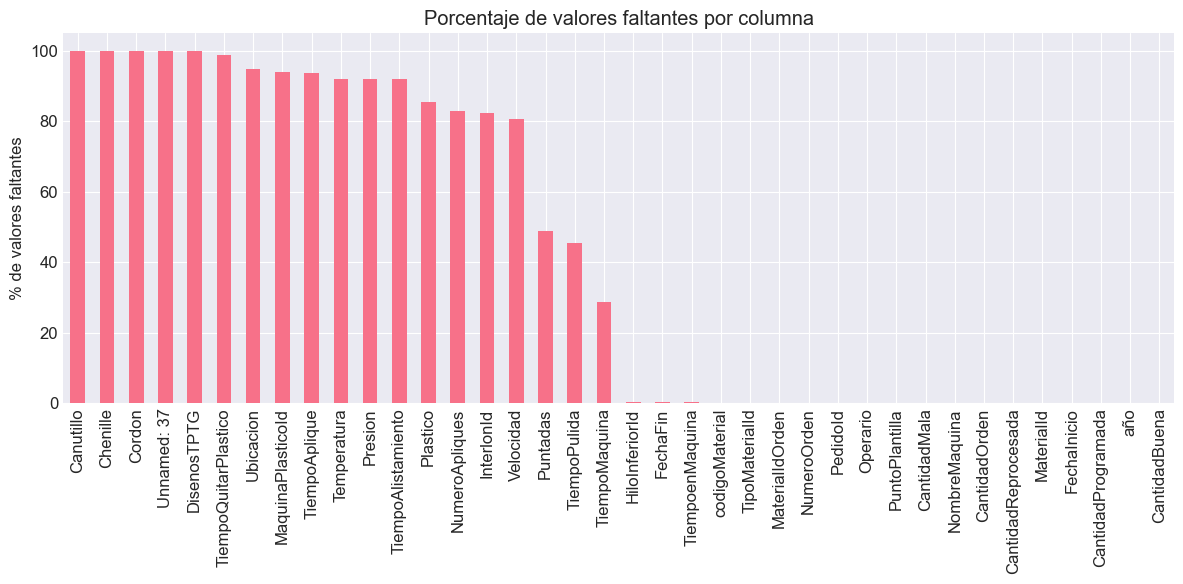

In [1817]:
# Porcentaje de nulos por columna
missing_pct = df.isna().mean() * 100  # serie: columna → %
missing_pct = missing_pct.sort_values(ascending=False)

print("Porcentaje de valores faltantes por columna:")

# Gráfico de barras de nulos
plt.figure(figsize=(12, 6))
missing_pct.plot(kind="bar")
plt.ylabel("% de valores faltantes")
plt.title("Porcentaje de valores faltantes por columna")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 3.3. Análisis Univariado: variables númericas

In [1818]:
num_cols_clave = [
    "TiempoenMaquina",
    "CantidadOrden",
    "CantidadProgramada",
    "CantidadBuena",
    "CantidadMala",
    "CantidadReprocesada",
    "Puntadas",
]

# Filtramos solo las que realmente existan en el df (por si acaso)
num_cols_clave = [c for c in num_cols_clave if c in df.columns]
print("Variables numéricas clave para explorar:", num_cols_clave)

Variables numéricas clave para explorar: ['TiempoenMaquina', 'CantidadOrden', 'CantidadProgramada', 'CantidadBuena', 'CantidadMala', 'CantidadReprocesada', 'Puntadas']


In [1819]:
from scipy import stats

def plot_univariate_diagnostics(df, num_cols_clave, pclip=0.99):
    """
    Para cada columna en num_cols_clave dibuja:
      - Histograma (<= percentil pclip)
      - Boxplot (<= percentil pclip)
      - Q-Q plot contra normal (<= percentil pclip)
    """
    cols = [c for c in num_cols_clave if c in df.columns]

    for col in cols:
        # -----------------------------
        # 1) Datos base de la columna
        # -----------------------------
        data = df[col].dropna().astype(float)
        if data.empty:
            print(f"Columna '{col}' sin datos, se omite.")
            continue

        upper = data.quantile(pclip)
        data_clip = data[data <= upper]

        if data_clip.empty:
            print(f"Columna '{col}' quedó vacía después de recortar a p{int(pclip*100)}.")
            continue

        # -----------------------------
        # Figura con 3 subplots (2x2 pero usamos 3)
        # -----------------------------
        fig, axes = plt.subplots(2, 2, figsize=(10, 7))
        fig.suptitle(f"Análisis univariado de {col}", fontsize=14)

        # (1) Histograma
        ax_hist = axes[0, 0]
        ax_hist.hist(data_clip, bins=30)
        ax_hist.set_title(f"Histograma ({col} <= p{int(pclip*100)})")
        ax_hist.set_xlabel(col)
        ax_hist.set_ylabel("Frecuencia")

        # (2) Boxplot
        ax_box = axes[0, 1]
        ax_box.boxplot(data_clip, vert=True)
        ax_box.set_title(f"Boxplot ({col} <= p{int(pclip*100)})")
        ax_box.set_xticks([1])
        ax_box.set_xticklabels([col])

        # (3) Q-Q plot
        ax_qq = axes[1, 0]
        stats.probplot(data_clip, dist="norm", plot=ax_qq)
        ax_qq.set_title(f"Q-Q plot normal ({col} <= p{int(pclip*100)})")

        # Dejamos el último subplot vacío
        ax_empty = axes[1, 1]
        ax_empty.axis("off")

        plt.tight_layout(rect=[0, 0, 1, 0.99])
        plt.show()

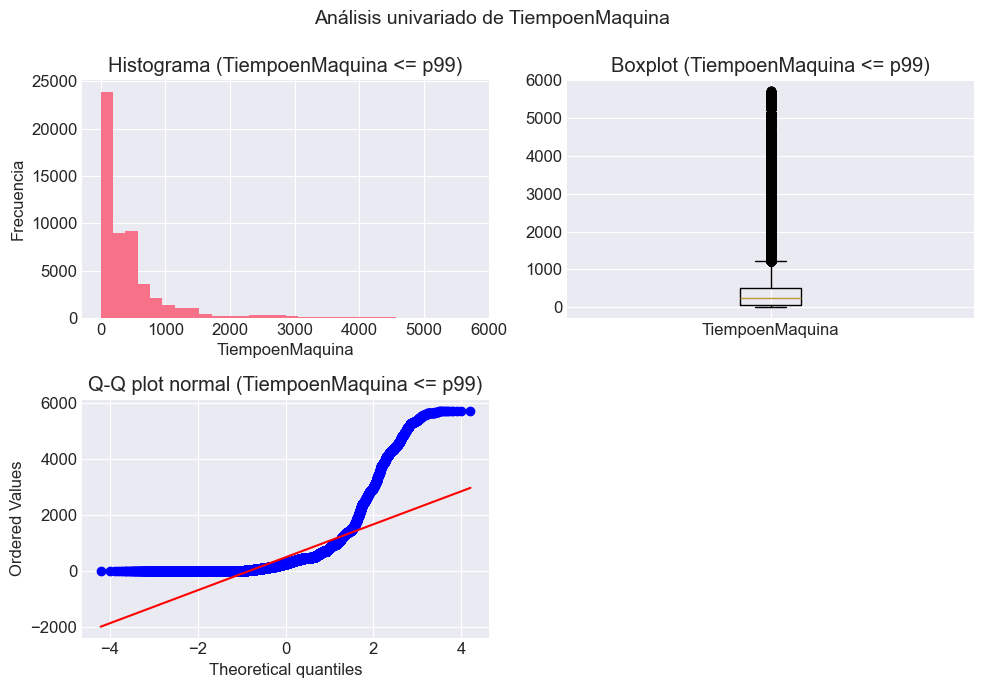

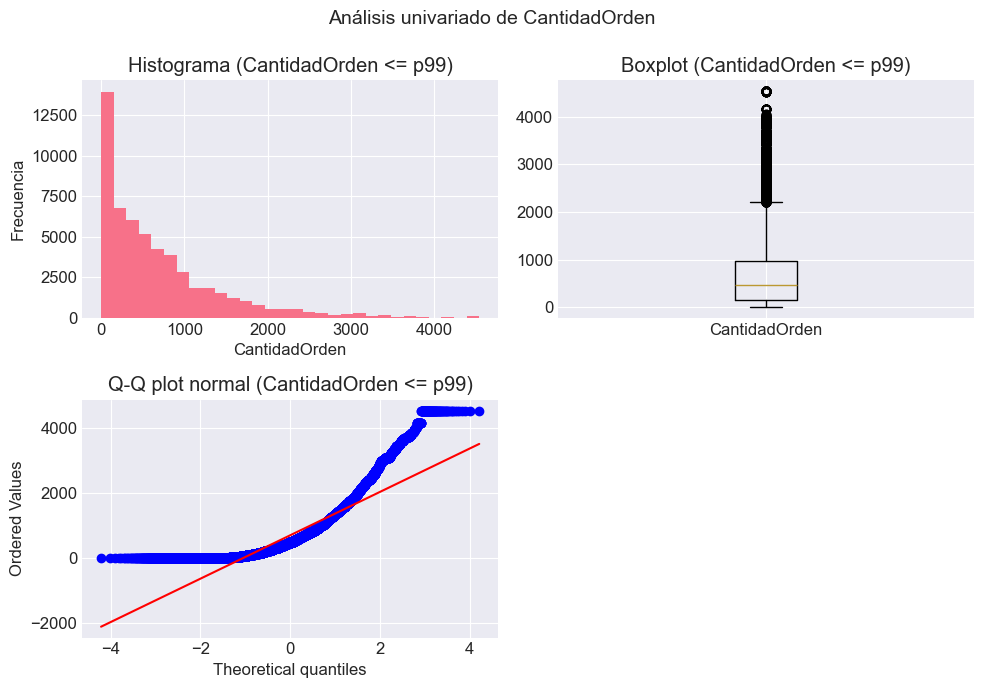

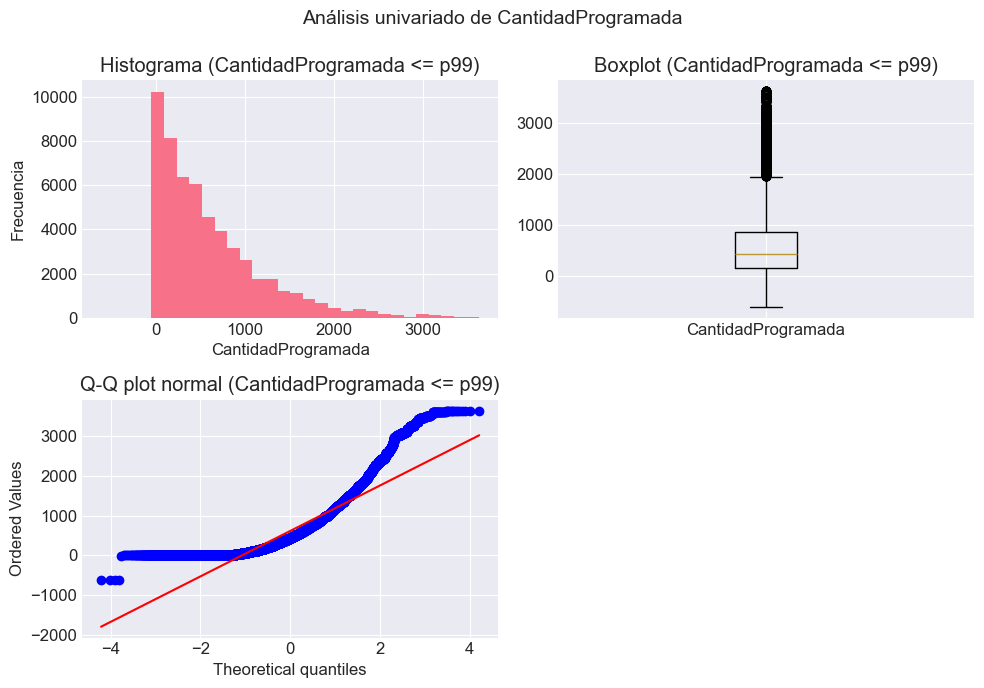

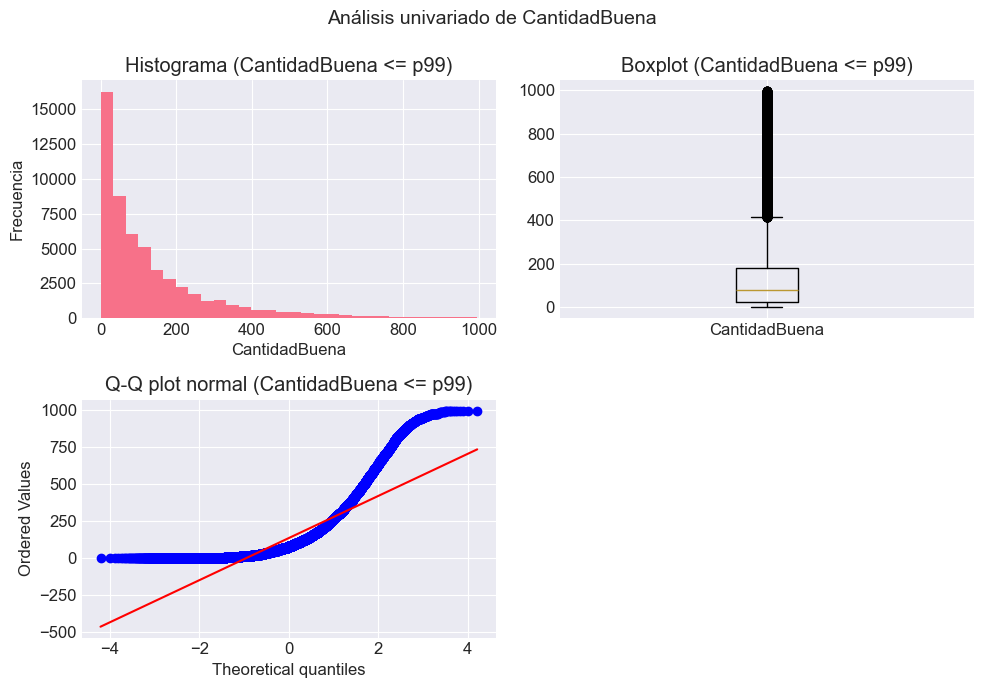

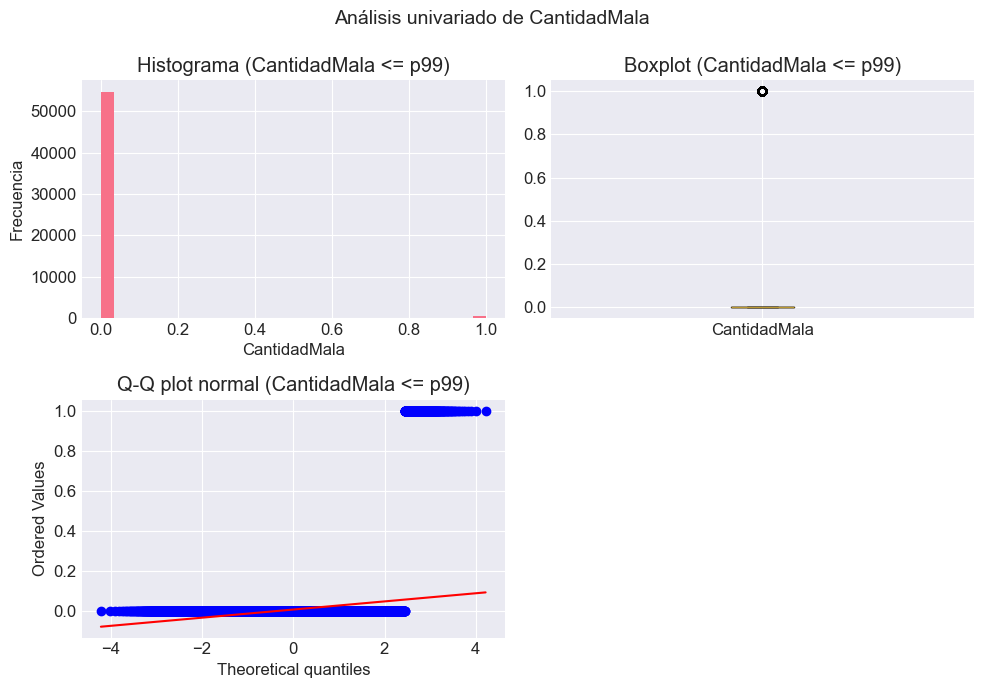

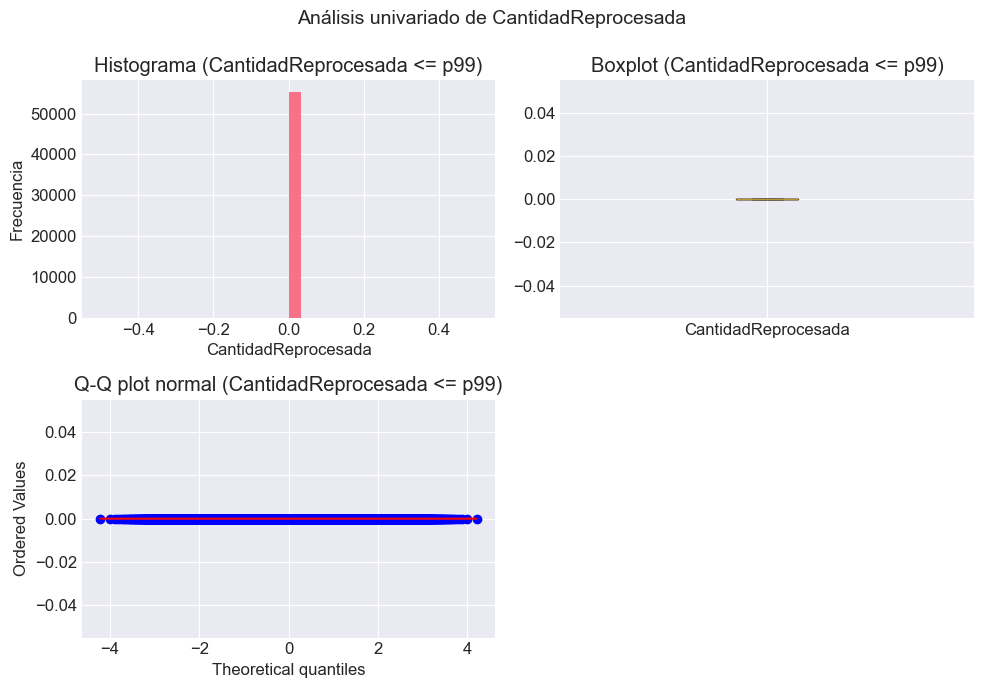

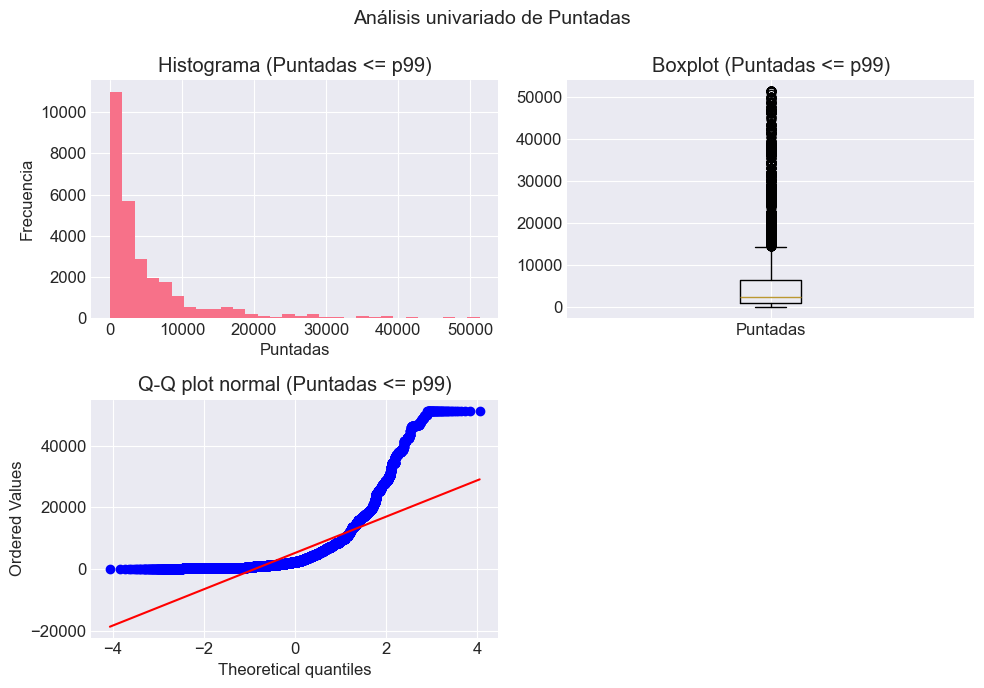

In [1820]:
plot_univariate_diagnostics(df, num_cols_clave, pclip=0.99)

Eliminacion de columnas irrelevantes explicar

### 3.4. Análisis de variables categóricas

In [1821]:
CAT_CONFIGS_PROD = [
    ("NombreMaquina", 10),
    ("Operario", 15),       # solo nombres, limpiados
    ("codigoMaterial", 10),
    ("dia_semana", None),
    ("turno", None),
]


def _agregar_dia_y_turno(data: pd.DataFrame) -> pd.DataFrame:
    """Deriva columnas dia_semana, hora y turno a partir de FechaInicio (si existe)."""
    data = data.copy()
    if "FechaInicio" in data.columns:
        data["FechaInicio_dt"] = pd.to_datetime(data["FechaInicio"], errors="coerce")
        data["dia_semana"] = data["FechaInicio_dt"].dt.day_name()
        data["hora"] = data["FechaInicio_dt"].dt.hour

        def clasificar_turno(h):
            if pd.isna(h):
                return np.nan
            if 6 <= h < 14:
                return "Mañana"
            elif 14 <= h < 22:
                return "Tarde"
            else:
                return "Noche"

        data["turno"] = data["hora"].apply(clasificar_turno)

    return data


# ==========================================================
# 1) FUNCIÓN SOLO DISTRIBUCIONES
# ==========================================================
def eda_categoricas_produccion_distribuciones(df: pd.DataFrame) -> None:
    """
    EDA de variables categóricas: SOLO distribuciones (barras + pie).

    NO depende del target, NO recibe target_col.
    """

    data = _agregar_dia_y_turno(df)

    for cat_col, top_n in CAT_CONFIGS_PROD:
        if cat_col not in data.columns:
            print(f"[INFO] Columna '{cat_col}' no existe en el DataFrame, se omite.")
            continue

        # Subconjunto solo con la categórica
        sub = data[[cat_col]].copy()

        # 1) Asegurar que la categórica esté como string limpio
        sub[cat_col] = sub[cat_col].astype(str).str.strip()

        # Limpieza especial SOLO para Operario: quedarnos solo con el primer nombre
        if cat_col == "Operario":
            sub[cat_col] = (
                sub[cat_col]
                .str.replace("nan", "", case=False)  # por si viene como texto "nan"
                .str.strip()
                .str.split()
                .str[0]  # primer token = primer nombre
            )

        # 2) Quitar nulos de la categórica
        sub = sub.replace("nan", np.nan)  # por si quedaron como texto "nan"
        sub = sub.dropna(subset=[cat_col])

        if sub.empty:
            print(f"[INFO] No hay datos válidos para {cat_col}, se omite.")
            continue

        # 3) Limitar a top_n categorías si aplica
        if top_n is not None:
            top_cats = sub[cat_col].value_counts().head(top_n).index
            sub = sub[sub[cat_col].isin(top_cats)]
            if sub.empty:
                print(
                    f"[INFO] Después de filtrar top categorías, {cat_col} quedó vacío, se omite."
                )
                continue

        print(f"\n=== Distribución categórica: {cat_col} ===")
        counts = sub[cat_col].value_counts()

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # ----- 1) Barras -----
        ax1 = axes[0]
        colors = plt.cm.Set3(range(len(counts)))
        x_pos = np.arange(len(counts))

        ax1.bar(x_pos, counts.values, color=colors)
        ax1.set_title(f"Distribución de {cat_col}")
        ax1.set_xlabel(cat_col)
        ax1.set_ylabel("Frecuencia")
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(counts.index, rotation=45, ha="right")

        total = len(sub)
        for i, (idx, val) in enumerate(counts.items()):
            ax1.text(
                i,
                val,
                f"{val}\n({val/total*100:.1f}%)",
                ha="center",
                va="bottom",
                fontsize=9,
            )

        # ----- 2) Pie chart -----
        ax2 = axes[1]
        ax2.pie(
            counts.values,
            labels=counts.index,
            autopct="%1.1f%%",
            colors=colors,
        )
        ax2.set_title(f"Proporción de {cat_col}")

        plt.suptitle(
            f"Distribución de variable categórica: {cat_col}",
            fontsize=14,
            fontweight="bold",
        )
        plt.tight_layout()
        plt.show()


=== Distribución categórica: NombreMaquina ===


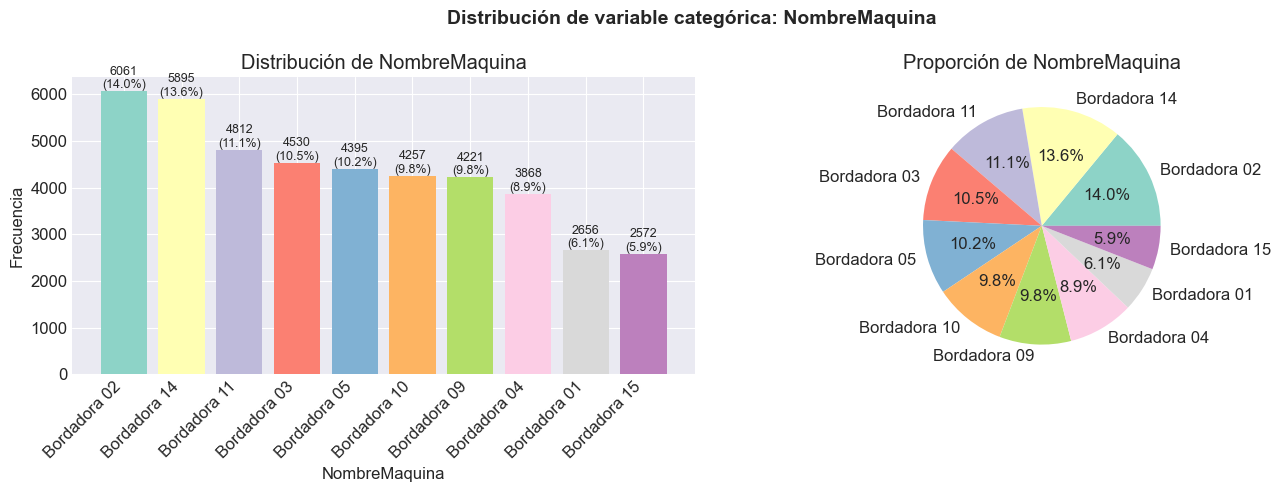


=== Distribución categórica: Operario ===


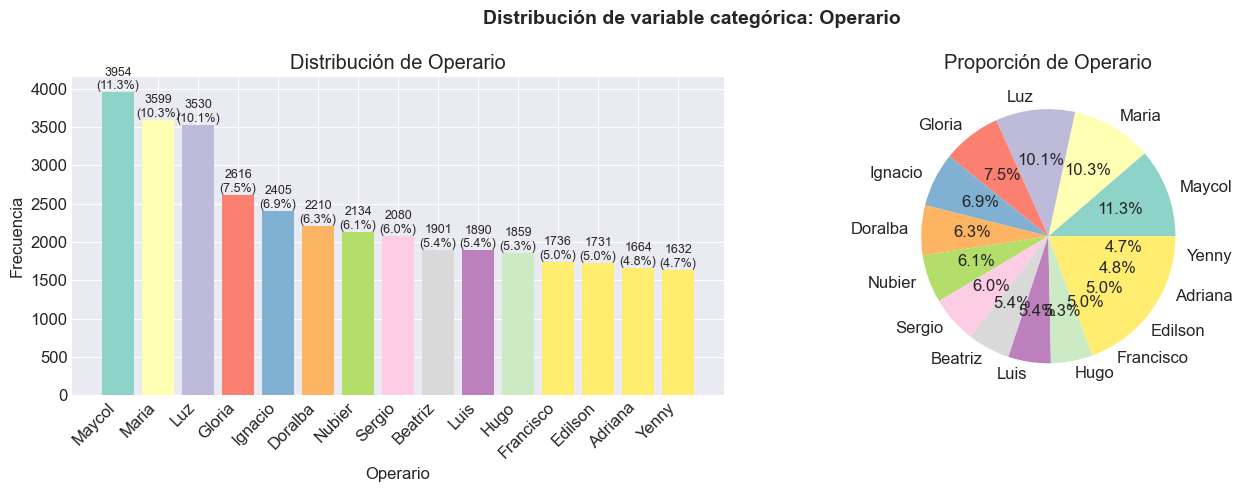


=== Distribución categórica: codigoMaterial ===


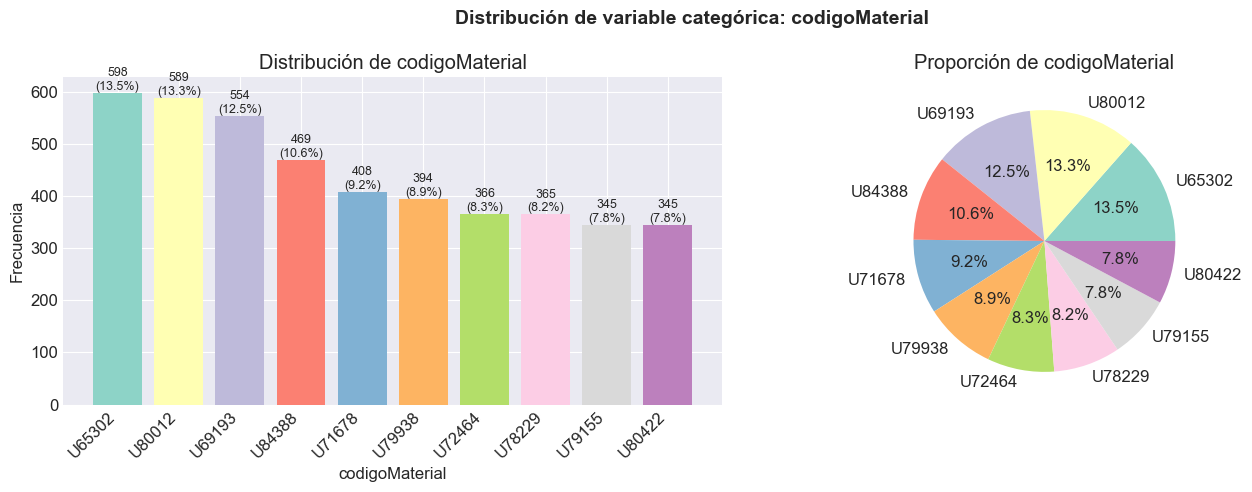


=== Distribución categórica: dia_semana ===


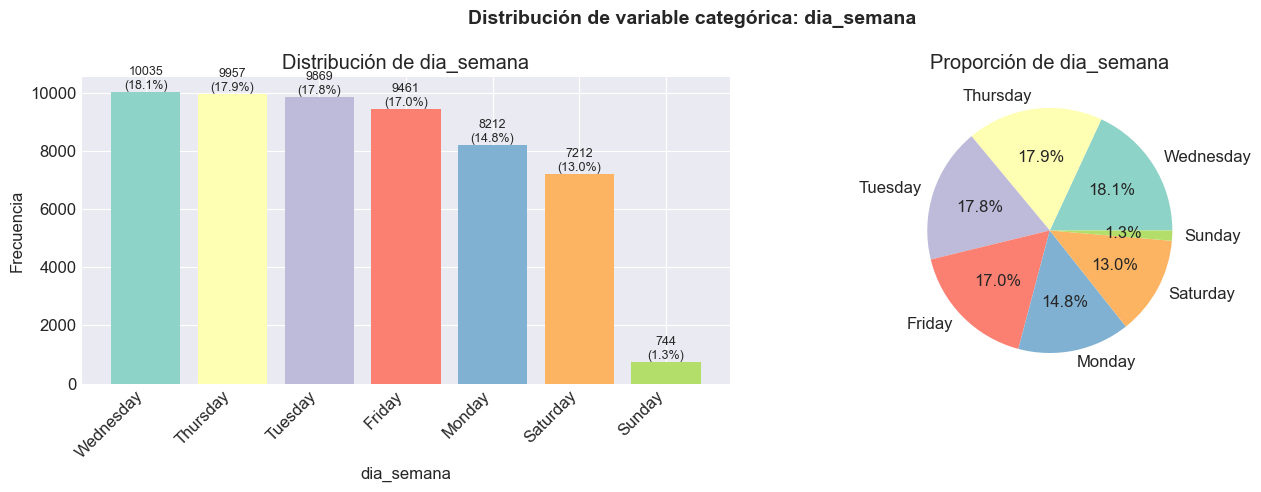


=== Distribución categórica: turno ===


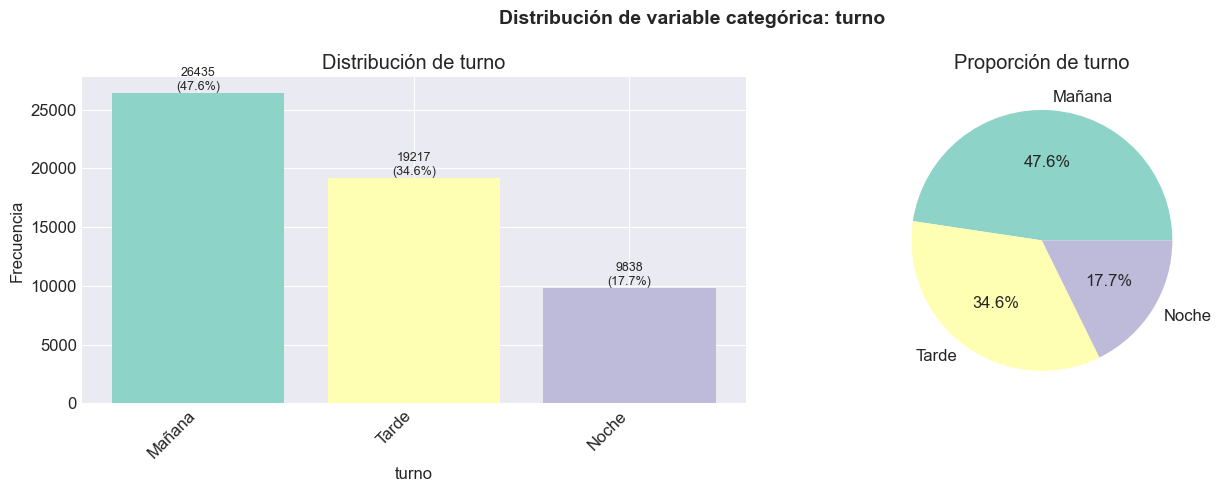

In [1822]:
eda_categoricas_produccion_distribuciones(df)

---
## 4. Preparación de los datos

In [1823]:
# Lista de columnas a eliminar
cols_to_drop = [
    "Plastico",
    "MaquinaPlasticoId",
    "TiempoQuitarPlastico",
    "Canutillo",
    "Chenille",
    "Cordon",
    "Presion",
    "Temperatura",
    "Unnamed: 37",
    "Velocidad",
    "NumeroApliques",
    "InterlonId",
    "DisenosTPTG",
    "Ubicacion",
    "TipoMaterialId",
    "MaterialId",
    "PedidoId",
    "NumeroOrden",

]

# Eliminarlas del dataframe
df = df.drop(columns=cols_to_drop, errors="ignore")

print("Columnas eliminadas:")
print(cols_to_drop)
print("\nNueva forma del dataset:", df.shape)
df


Columnas eliminadas:
['Plastico', 'MaquinaPlasticoId', 'TiempoQuitarPlastico', 'Canutillo', 'Chenille', 'Cordon', 'Presion', 'Temperatura', 'Unnamed: 37', 'Velocidad', 'NumeroApliques', 'InterlonId', 'DisenosTPTG', 'Ubicacion', 'TipoMaterialId', 'MaterialId', 'PedidoId', 'NumeroOrden']

Nueva forma del dataset: (55490, 20)


,Operario,MaterialIdOrden,codigoMaterial,CantidadOrden,NombreMaquina,CantidadProgramada,FechaInicio,FechaFin,año,TiempoenMaquina,CantidadBuena,CantidadMala,CantidadReprocesada,PuntoPlantilla,HiloInferiorId,TiempoAlistamiento,TiempoMaquina,TiempoAplique,TiempoPulida,Puntadas
0,Edward Dario Pulgarin Paniagua,1625,U53554,241,Bordadora 12,241,2021-06-15 11:21:39.9748690,2021-06-15 17:41:58.7622990,2021,380.00,162,0,0,1,91.00,NaN,NaN,NaN,NaN,1735.00
1,Edward Dario Pulgarin Paniagua,1625,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.00,471,0,0,1,91.00,NaN,NaN,NaN,NaN,1735.00
2,Edwin Alonso Jaramillo Castaño,1625,U53554,544,Bordadora 12,544,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.00,5,0,0,1,91.00,NaN,NaN,NaN,NaN,1735.00
3,Francisco Nicolas Parra Acevedo,1625,U53554,10,Bordadora 05,10,2021-03-08 10:38:09.8705291,2021-03-08 11:25:26.7423458,2021,47.00,10,0,0,1,91.00,NaN,NaN,NaN,NaN,1735.00
4,Gloria Elsy Jimenez Giraldo,1625,U53554,40,Bordadora 14,40,2020-07-07 21:00:57.3642183,2020-07-07 21:27:32.5160898,2020,27.00,13,0,0,1,91.00,NaN,NaN,NaN,NaN,1735.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55485,Doralba Maria Amariles Madrigal,40425,U90747,40,Bordadora 06,40,2025-10-08 15:09:29.0006427,2025-10-08 15:42:10.1142210,2025,33.00,6,0,0,0,91.00,NaN,NaN,NaN,NaN,NaN
55486,Ignacio Aristizabal Borja,40425,U90747,40,Bordadora 06,40,2025-10-09 12:10:16.3000934,2025-10-10 08:13:03.5795825,2025,1203.00,34,0,0,0,91.00,NaN,NaN,NaN,NaN,NaN
55487,Doralba Maria Amariles Madrigal,40434,U90750,20,Bordadora 06,20,2025-10-14 14:09:02.7085376,2025-10-14 14:52:30.6080336,2025,43.00,20,0,0,0,91.00,NaN,00:08:43.0000000,NaN,NaN,NaN
55488,Iliana Del Carmen Gonzalez Duran,40516,U90774,185,Bordadora 17,185,2025-10-10 03:07:43.5148904,2025-10-10 04:23:33.3393816,2025,76.00,17,0,0,0,91.00,NaN,NaN,NaN,NaN,NaN


### 4.1. Estandarización de tipos (fechas, numéricas, categóricas)

El objetivo de esta etapa es garantizar que las principales variables del dataset estén representadas con los tipos de datos adecuados para su posterior análisis y modelado. Se aplican las siguientes reglas:

- **Fechas** → convertir a `datetime`, permitiendo valores faltantes.
- **Variables categóricas** → convertir a `category` para optimizar memoria y facilitar análisis estadístico.
- **Identificadores** → mantener como `string` para evitar pérdidas de formato (por ejemplo, ceros a la izquierda).


In [1824]:
df_raw = df.copy()

# --- Conversión de fechas ---
fecha_cols = [ "FechaInicio", "FechaFin"]
for col in fecha_cols:
    if col in df_raw.columns:
        df_raw[col] = pd.to_datetime(df_raw[col], errors="coerce")

# --- Conversión a categorías (ajustable según el diccionario de variables) ---
cat_cols = [
     "Operario", "NombreMaquina"
]
for col in cat_cols:
    if col in df_raw.columns:
        df_raw[col] = df_raw[col].astype("category")

# --- Identificadores → conservar como texto para evitar distorsiones numéricas ---
id_cols = [
    "PedidoId", "NumeroPedido",
    "NumeroOrden", "codigoMaterial",
    "MaterialIdOrden", "MaterialId",
]
for col in id_cols:
    if col in df_raw.columns:
        df_raw[col] = df_raw[col].astype(str)

# --- Validación posterior ---
print("Tipos de datos después de estandarización:")
display(df_raw.dtypes.to_frame("dtype").T)  # Vista compacta


Tipos de datos después de estandarización:


,Operario,MaterialIdOrden,codigoMaterial,CantidadOrden,NombreMaquina,CantidadProgramada,FechaInicio,FechaFin,año,TiempoenMaquina,CantidadBuena,CantidadMala,CantidadReprocesada,PuntoPlantilla,HiloInferiorId,TiempoAlistamiento,TiempoMaquina,TiempoAplique,TiempoPulida,Puntadas
dtype,category,object,object,int64,category,int64,datetime64[ns],datetime64[ns],int64,float64,int64,int64,int64,object,float64,object,object,object,object,float64


---

### 4.2. Construcción del Target y Cohortes (editar)

**4.2.1. Cálculo de `lead_time_total_horas` y `cycle_time_horas`**  
Se define la variable objetivo como la duración total entre `FechaIngreso` y `FechaFin` (en horas). De forma complementaria, `cycle_time_horas` mide la duración entre `FechaInicio` y `FechaFin` (útil para diagnóstico interno). Se corrigen valores negativos y se filtran outliers extremos.

In [1825]:
# Partimos del df_raw original
df_std = df_raw.copy()

# 1) Convertir columnas de formato "hh:mm:ss.0000000" a minutos
cols_hhmm = ["TiempoAlistamiento", "TiempoMaquina", "TiempoAplique", "TiempoPulida"]

for c in cols_hhmm:
    if c in df_std.columns:
        df_std[c + "_min"] = (
            pd.to_timedelta(df_std[c], errors="coerce")
              .dt.total_seconds() / 60
        )

# 2) TiempoenMaquina ya está en minutos, no hay que convertirlo
# Creamos el total en minutos usando fillna(0) SOLO para la suma
df_std["tiempo_total_min"] = (
    df_std["TiempoenMaquina"].fillna(0)
    + df_std.get("TiempoAlistamiento_min", 0).fillna(0)
    + df_std.get("TiempoMaquina_min", 0).fillna(0)
    + df_std.get("TiempoAplique_min", 0).fillna(0)
    + df_std.get("TiempoPulida_min", 0).fillna(0)
)

# 3) Filtrar filas para modelado:
#    SOLO eliminamos filas donde TIEMPOENMAQUINA está vacío (NaN)
mask_sin_target = df_std["TiempoenMaquina"].isna()

print("Filas con TiempoenMaquina vacío (sin target):", mask_sin_target.sum())

# Dataset para modelado: solo filas que SÍ tienen TiempoenMaquina
df_model = df_std.loc[~mask_sin_target].copy()

print("Shape df_std (completo):", df_std.shape)
print("Shape df_model (para modelo):", df_model.shape)

# Vista rápida para verificar
cols_vista = [
    "TiempoenMaquina",
    "TiempoAlistamiento", "TiempoAlistamiento_min",
    "TiempoMaquina", "TiempoMaquina_min",
    "TiempoAplique", "TiempoAplique_min",
    "TiempoPulida", "TiempoPulida_min",
    "tiempo_total_min",
]
display(df_model[cols_vista].head(10))


Filas con TiempoenMaquina vacío (sin target): 188
Shape df_std (completo): (55490, 25)
Shape df_model (para modelo): (55302, 25)


,TiempoenMaquina,TiempoAlistamiento,TiempoAlistamiento_min,TiempoMaquina,TiempoMaquina_min,TiempoAplique,TiempoAplique_min,TiempoPulida,TiempoPulida_min,tiempo_total_min
0,380.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.00
1,6910.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6910.00
2,6910.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6910.00
3,47.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.00
4,27.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.00
5,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
6,38.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.00
7,127.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.00
8,280.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,280.00
9,117.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.00


### Análisis Univariado

In [1826]:
def plot_scatter_vs_target(df, num_cols_clave, target_col="tiempo_total_min", pclip=0.99):
    """
    Para cada columna en num_cols_clave dibuja SOLO:
      - Scatter vs target_col (<= percentil pclip en x e y)
    """
    cols = [c for c in num_cols_clave if c in df.columns]

    if target_col not in df.columns:
        print(f"❌ La columna target '{target_col}' no existe en el DataFrame.")
        return

    for col in cols:
        # No tiene sentido scatter de target contra sí mismo
        if col == target_col:
            print(f"Columna '{col}' es el target, se omite scatter.")
            continue

        # Quitamos nulos en ambas columnas
        data_scatter = df[[col, target_col]].dropna().astype(float)

        if data_scatter.empty:
            print(f"Sin datos para scatter entre '{col}' y '{target_col}'.")
            continue

        x = data_scatter[col].values
        y = data_scatter[target_col].values

        # Recorte a pclip en ambas variables
        x_max = np.quantile(x, pclip)
        y_max = np.quantile(y, pclip)
        mask = (x <= x_max) & (y <= y_max)

        x_clip_s = x[mask]
        y_clip_s = y[mask]

        if x_clip_s.size == 0:
            print(f"Scatter '{col}' vs '{target_col}' quedó vacío después de recortar.")
            continue

        plt.figure(figsize=(6, 4))
        plt.scatter(x_clip_s, y_clip_s, s=5, alpha=0.5)
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.title(f"{target_col} vs {col}\n(<= p{int(pclip*100)} en ambas)")
        plt.tight_layout()
        plt.show()

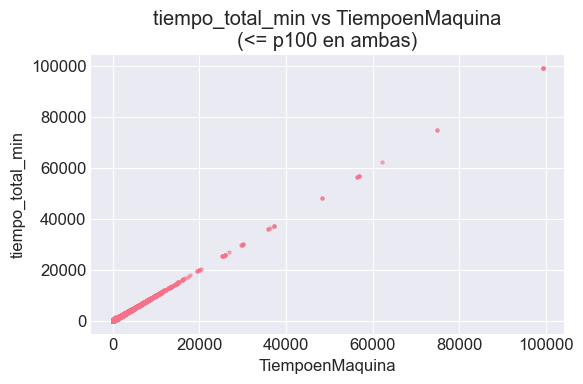

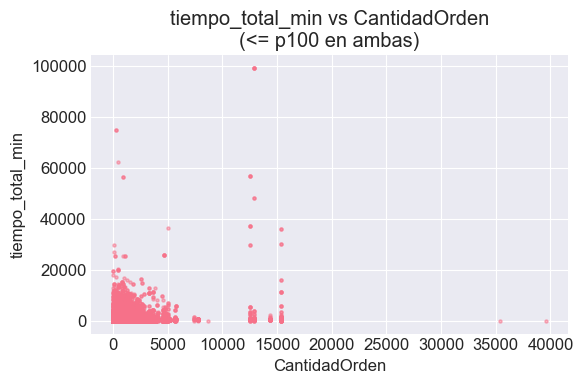

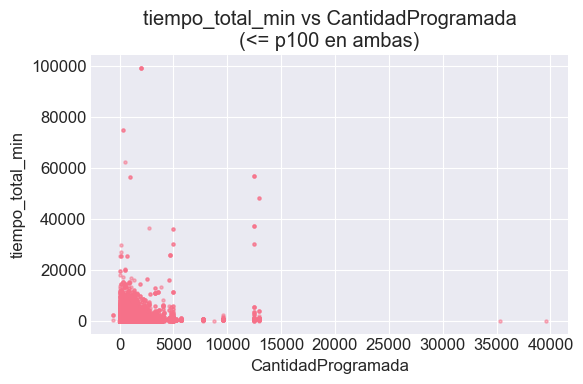

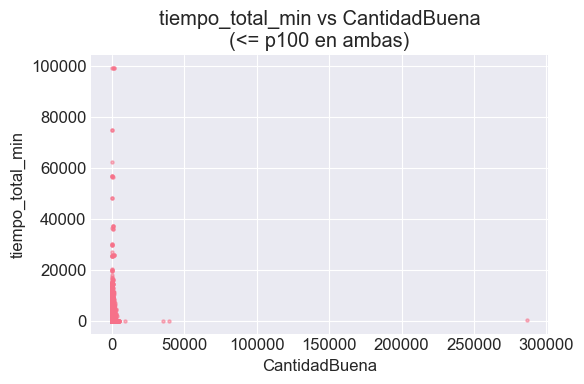

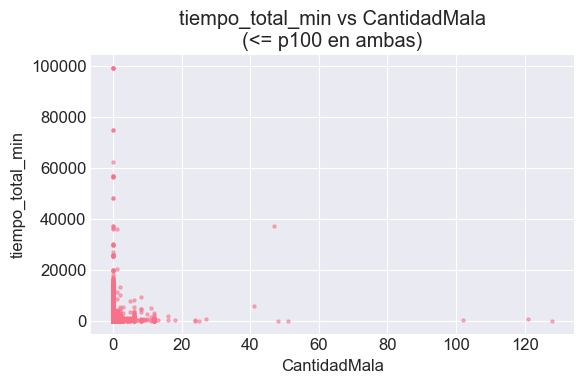

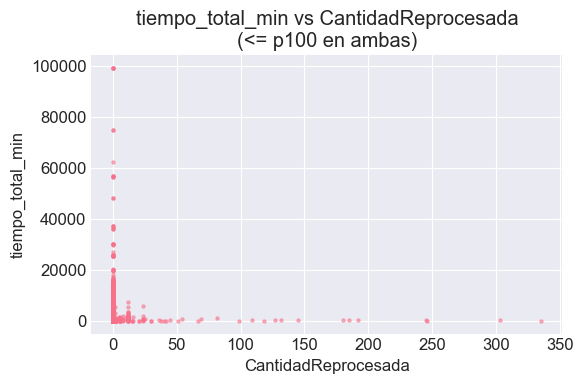

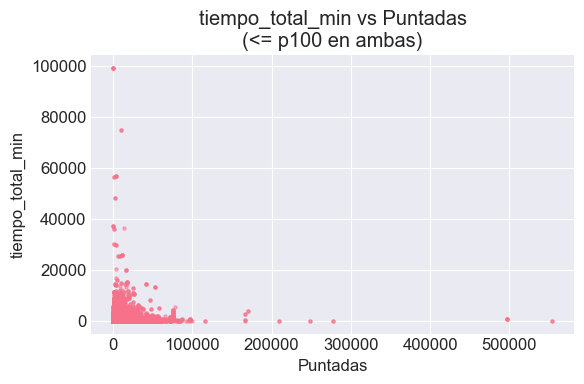

In [1827]:
plot_scatter_vs_target(df_model, num_cols_clave, target_col="tiempo_total_min", pclip=1)

### Análisis de variables categóricas

In [1828]:
def eda_categoricas_produccion_vs_target(
    df: pd.DataFrame, target_col: str = "tiempo_total_min"
) -> None:
    """
    EDA de variables categóricas vs target.

    Genera, para cada categórica:
      - Boxplot del target por categoría
      - Tabla de stats (N, media, mediana, desv.est.)

    AQUÍ SÍ se usa y se requiere el parámetro target_col.
    """

    data = _agregar_dia_y_turno(df)

    if target_col not in data.columns:
        print(f"[ERROR] La columna target '{target_col}' no existe en el DataFrame.")
        return

    for cat_col, top_n in CAT_CONFIGS_PROD:
        if cat_col not in data.columns:
            print(f"[INFO] Columna '{cat_col}' no existe en el DataFrame, se omite.")
            continue

        # Subconjunto con cat + target
        sub = data[[cat_col, target_col]].copy()

        # 1) Asegurar que la categórica esté como string limpio
        sub[cat_col] = sub[cat_col].astype(str).str.strip()

        # Limpieza especial SOLO para Operario: primer nombre
        if cat_col == "Operario":
            sub[cat_col] = (
                sub[cat_col]
                .str.replace("nan", "", case=False)
                .str.strip()
                .str.split()
                .str[0]
            )

        # 2) Quitar nulos del target y de la categórica
        sub = sub.replace("nan", np.nan)
        sub = sub.dropna(subset=[cat_col, target_col])

        if sub.empty:
            print(
                f"[INFO] No hay datos válidos para {cat_col} vs {target_col}, se omite."
            )
            continue

        # 3) Limitar a top_n categorías si aplica
        if top_n is not None:
            top_cats = sub[cat_col].value_counts().head(top_n).index
            sub = sub[sub[cat_col].isin(top_cats)]
            if sub.empty:
                print(
                    f"[INFO] Después de filtrar top categorías, {cat_col} quedó vacío, se omite."
                )
                continue

        print(f"\n=== Análisis categórico: {cat_col} vs {target_col} ===")

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # ----- 1) Boxplot del target por categoría -----
        ax1 = axes[0]
        sub.boxplot(column=target_col, by=cat_col, ax=ax1)
        ax1.set_title(f"{target_col} por {cat_col}")
        ax1.set_xlabel(cat_col)
        ax1.set_ylabel(target_col)
        plt.sca(ax1)
        plt.xticks(rotation=45)
        for label in ax1.get_xticklabels():
            label.set_ha("right")
        ax1.grid(alpha=0.3)

        # ----- 2) Tabla de estadísticas por categoría -----
        ax2 = axes[1]
        ax2.axis("off")

        stats_by_cat = (
            sub.groupby(cat_col)[target_col]
            .agg(["count", "mean", "median", "std"])
            .round(2)
        )

        table_data = []
        for idx, row in stats_by_cat.iterrows():
            table_data.append(
                [
                    idx,
                    f"{row['count']:.0f}",
                    f"{row['mean']:.2f}",
                    f"{row['median']:.2f}",
                    f"{row['std']:.2f}",
                ]
            )

        table = ax2.table(
            cellText=table_data,
            colLabels=["Categoría", "N", "Media", "Mediana", "Desv.Est."],
            cellLoc="center",
            loc="center",
            colWidths=[0.3, 0.12, 0.15, 0.15, 0.15],
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)

        # encabezado en turquesa
        for i in range(5):
            cell = table[(0, i)]
            cell.set_facecolor("#40E0D0")
            cell.set_text_props(weight="bold")

        plt.suptitle(
            f"Análisis de variable categórica: {cat_col} vs {target_col}",
            fontsize=14,
            fontweight="bold",
        )
        plt.tight_layout()
        plt.show()


=== Análisis categórico: NombreMaquina vs tiempo_total_min ===


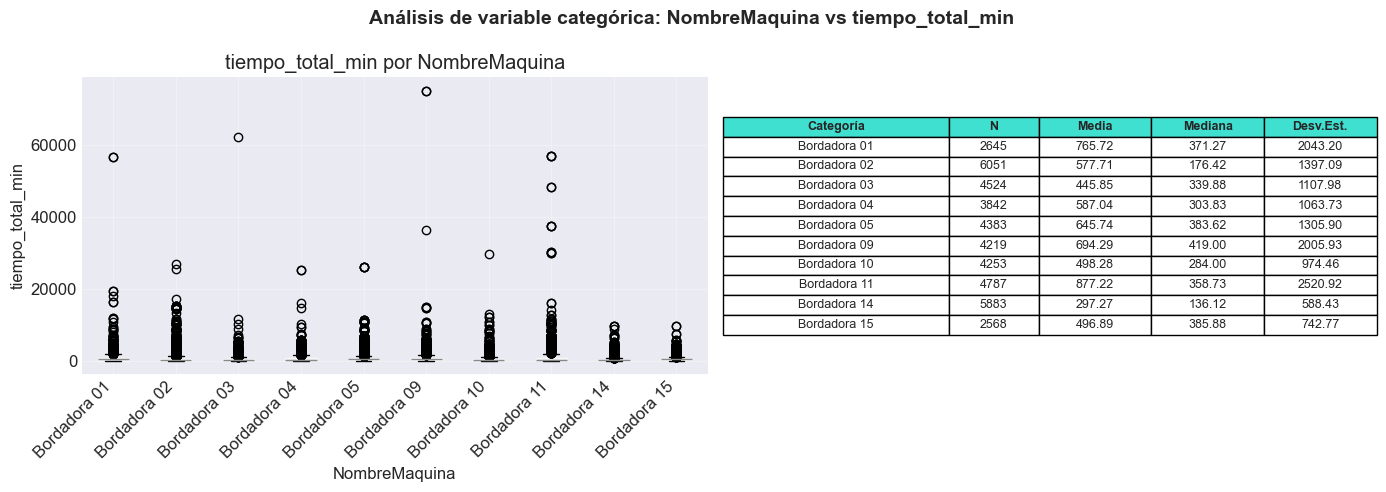


=== Análisis categórico: Operario vs tiempo_total_min ===


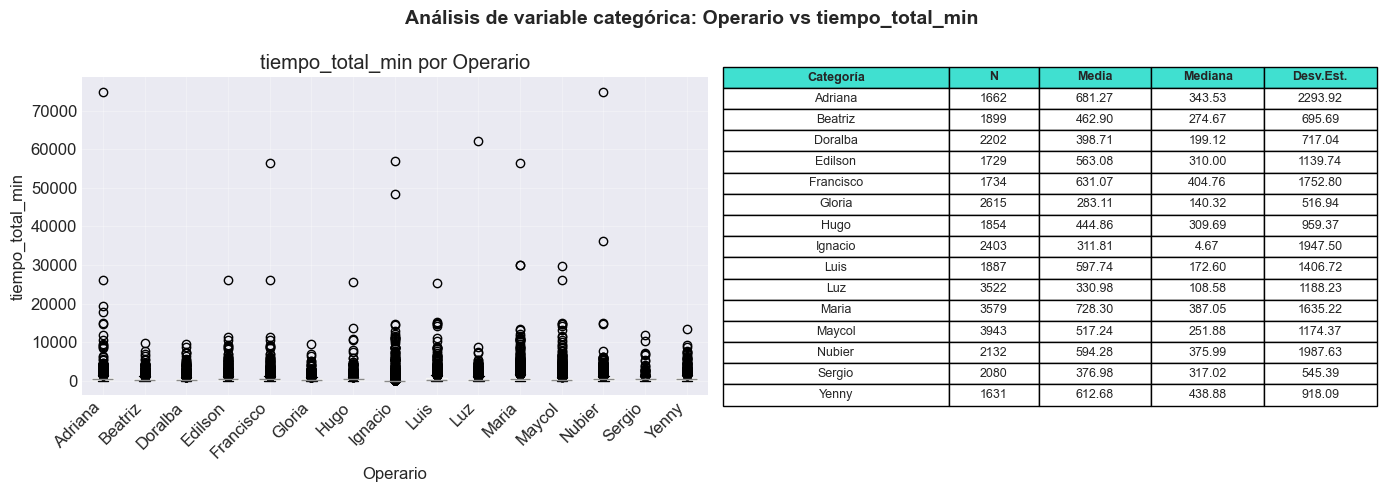


=== Análisis categórico: codigoMaterial vs tiempo_total_min ===


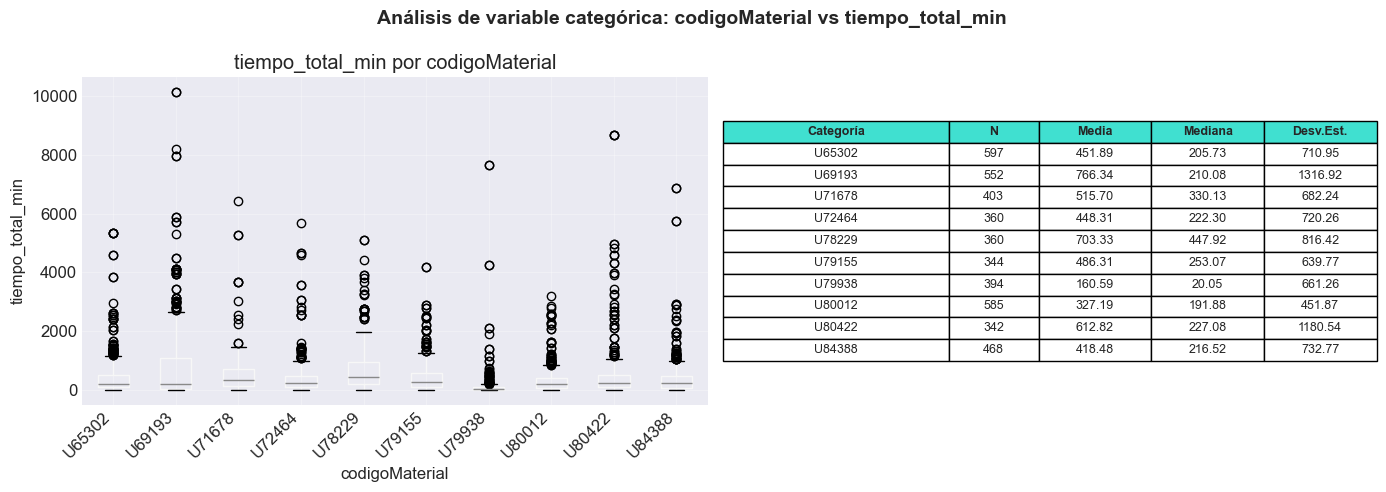


=== Análisis categórico: dia_semana vs tiempo_total_min ===


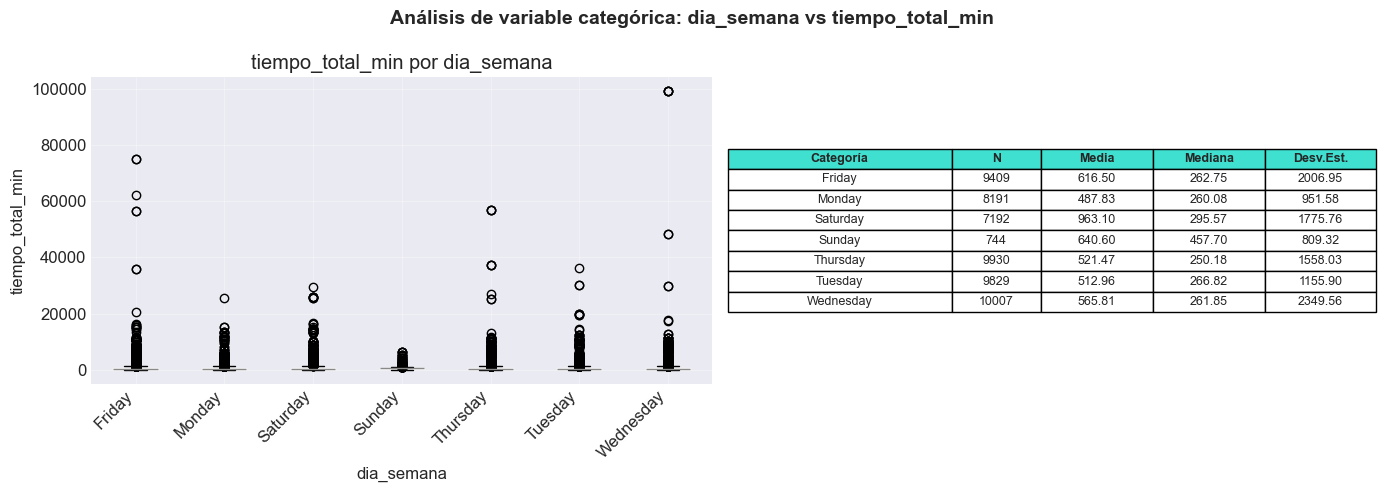


=== Análisis categórico: turno vs tiempo_total_min ===


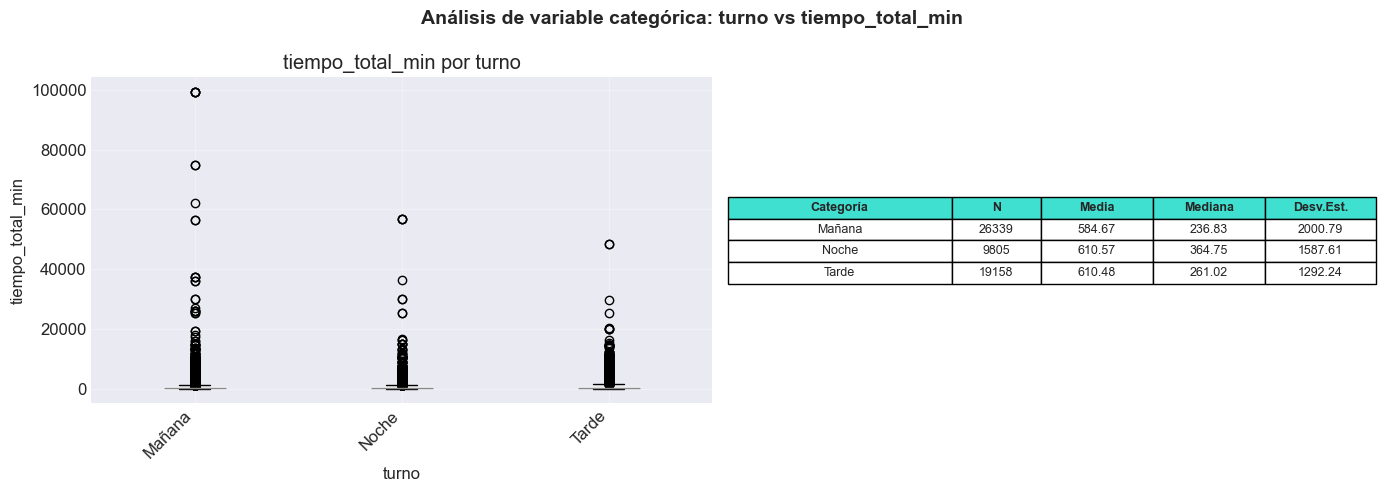

In [1829]:
eda_categoricas_produccion_vs_target(df_model, target_col="tiempo_total_min")

### 4.4 Eliminación de columnas

In [1830]:
# Lista de columnas a eliminar
cols_to_drop = [
    "Plastico",
    "MaquinaPlasticoId",
    "TiempoQuitarPlastico",
    "Canutillo",
    "Chenille",
    "Cordon",
    "Presion",
    "Temperatura",
    "Unnamed: 37",
    "Velocidad",
    "NumeroApliques",
    "InterlonId",
    "DisenosTPTG",
    "Ubicacion",
    "TipoMaterialId",
    "CantidadProgramada",
    "MaterialId",
    "PedidoId",
    "NumeroOrden",
    "codigoMaterial",

]

# Eliminarlas del dataframe
df = df.drop(columns=cols_to_drop, errors="ignore")

print("Columnas eliminadas:")
print(cols_to_drop)
print("\nNueva forma del dataset:", df.shape)
df


Columnas eliminadas:
['Plastico', 'MaquinaPlasticoId', 'TiempoQuitarPlastico', 'Canutillo', 'Chenille', 'Cordon', 'Presion', 'Temperatura', 'Unnamed: 37', 'Velocidad', 'NumeroApliques', 'InterlonId', 'DisenosTPTG', 'Ubicacion', 'TipoMaterialId', 'CantidadProgramada', 'MaterialId', 'PedidoId', 'NumeroOrden', 'codigoMaterial']

Nueva forma del dataset: (55490, 18)


,Operario,MaterialIdOrden,CantidadOrden,NombreMaquina,FechaInicio,FechaFin,año,TiempoenMaquina,CantidadBuena,CantidadMala,CantidadReprocesada,PuntoPlantilla,HiloInferiorId,TiempoAlistamiento,TiempoMaquina,TiempoAplique,TiempoPulida,Puntadas
0,Edward Dario Pulgarin Paniagua,1625,241,Bordadora 12,2021-06-15 11:21:39.9748690,2021-06-15 17:41:58.7622990,2021,380.00,162,0,0,1,91.00,NaN,NaN,NaN,NaN,1735.00
1,Edward Dario Pulgarin Paniagua,1625,544,Bordadora 12,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.00,471,0,0,1,91.00,NaN,NaN,NaN,NaN,1735.00
2,Edwin Alonso Jaramillo Castaño,1625,544,Bordadora 12,2021-06-18 11:37:35.9040465,2021-06-23 06:47:54.1423484,2021,6910.00,5,0,0,1,91.00,NaN,NaN,NaN,NaN,1735.00
3,Francisco Nicolas Parra Acevedo,1625,10,Bordadora 05,2021-03-08 10:38:09.8705291,2021-03-08 11:25:26.7423458,2021,47.00,10,0,0,1,91.00,NaN,NaN,NaN,NaN,1735.00
4,Gloria Elsy Jimenez Giraldo,1625,40,Bordadora 14,2020-07-07 21:00:57.3642183,2020-07-07 21:27:32.5160898,2020,27.00,13,0,0,1,91.00,NaN,NaN,NaN,NaN,1735.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55485,Doralba Maria Amariles Madrigal,40425,40,Bordadora 06,2025-10-08 15:09:29.0006427,2025-10-08 15:42:10.1142210,2025,33.00,6,0,0,0,91.00,NaN,NaN,NaN,NaN,NaN
55486,Ignacio Aristizabal Borja,40425,40,Bordadora 06,2025-10-09 12:10:16.3000934,2025-10-10 08:13:03.5795825,2025,1203.00,34,0,0,0,91.00,NaN,NaN,NaN,NaN,NaN
55487,Doralba Maria Amariles Madrigal,40434,20,Bordadora 06,2025-10-14 14:09:02.7085376,2025-10-14 14:52:30.6080336,2025,43.00,20,0,0,0,91.00,NaN,00:08:43.0000000,NaN,NaN,NaN
55488,Iliana Del Carmen Gonzalez Duran,40516,185,Bordadora 17,2025-10-10 03:07:43.5148904,2025-10-10 04:23:33.3393816,2025,76.00,17,0,0,0,91.00,NaN,NaN,NaN,NaN,NaN


---
# 5. Diccionario y Agrupación de Variables

### 5.1 Agrupación y descripción de variables

| Grupo | Variables | Propósito |
|------|-----------|-----------|
| Identificadores / Llaves | `PedidoId`, `NumeroPedido`, `PedidoDetalleId`, `NumeroOrden`, `MaterialIdOrden`, `MaterialId` | Identificar registros y permitir uniones. No aportan señal para el modelo. |
| Temporal | `FechaIngreso`, `FechaInicio`, `FechaFin`, `año` | Medir tiempos (lead time y cycle time) y análisis estacional. |
| Tamaño / Carga del Pedido | `Cantidad`, `CantidadOrden`, `CantidadProgramada`, `NumeroTulas`, `OrdenesGeneradas` | Representan volumen y planificación del pedido o lote. |
| Producto / Variante | `Talla`, `Fondo`, `ColorFondo`, `MaterialPedido`, `codigoMaterial` | Describen características visuales o comerciales del producto. |
| Materialidad / Receta | `TipoMaterialId`, `InterlonId`, `HiloInferiorId`, `Plastico`, `Canutillo`, `Chenille`, `Cordon` | Definen la composición y materiales que afectan proceso y tiempo. |
| Complejidad de Diseño | `DisenosTPTG`, `NumeroApliques`, `Puntadas`, `PuntoPlantilla` | Miden complejidad del producto y nivel de trabajo requerido. |
| Recursos / Asignación | `NombreMaquina`, `MaquinaPlasticoId`, `Operario`, `Ubicacion` | Indican la máquina, operario o ubicación donde se procesa. |
| Tiempos de Proceso | `TiempoAlistamiento`, `TiempoMaquina`, `TiempoAplique`, `TiempoPulida`, `TiempoQuitarPlastico`, `TiempoenMaquina` | Registrar tiempos operativos reales utilizados en cada fase. |
| Telemetría de Operación | `Velocidad`, `Presion`, `Temperatura` | Indicadores de condiciones de operación de la máquina. |
| Calidad / Resultado | `CantidadBuena`, `CantidadMala`, `CantidadReprocesada` | Medidas de rendimiento y retrabajo del proceso. |



### 5.2  Diccionario de datos (metadata)


#### Identificadores / Llaves

| Campo              | Tipo sugerido | Unidad | Descripción                                                          | Ejemplo            | Nulos |
|--------------------|---------------|--------|----------------------------------------------------------------------|--------------------|-------|
| PedidoId           | int64/string  | —      | Identificador interno del pedido.                                    | 125487             | No    |
| NumeroPedido       | string        | —      | Código/folio visible del pedido.                                     | "PO-2024-000981"   | No    |
| PedidoDetalleId    | int64/string  | —      | Identificador de la línea/detalle del pedido.                        | 881234             | No    |
| NumeroOrden        | string        | —      | Orden de producción asociada.                                        | "OP-77831"         | Sí     |
| MaterialIdOrden    | string        | —      | Id del material específico en la orden.                              | "MAT-ORD-009"      | Sí     |
| MaterialId         | string        | —      | Id de material genérico/catalogado.                                  | "MAT-00123"        | Sí     |

#### Temporal

| Campo         | Tipo sugerido     | Unidad | Descripción                                                         | Ejemplo               | Nulos             |
|---------------|-------------------|--------|---------------------------------------------------------------------|-----------------------|-------------------|
| FechaIngreso  | datetime64[ns]    | —      | Fecha/hora en que el pedido ingresa al sistema.                     | 2024-03-05 08:12:00   | No                |
| FechaInicio   | datetime64[ns]    | —      | Inicio de producción del detalle/pedido.                            | 2024-03-06 14:30:00   | Sí (obs. ~24%)    |
| FechaFin      | datetime64[ns]    | —      | Fin de producción/cierre del detalle/pedido.                        | 2024-03-08 10:05:00   | Sí (obs. ~24%)    |
| año           | int64             | —      | Año calendario de referencia (redundante si se extrae de fechas).   | 2024                  | Sí                |

#### Tamaño / Carga del pedido

| Campo               | Tipo sugerido | Unidad  | Descripción                                              | Ejemplo | Nulos |
|---------------------|---------------|---------|----------------------------------------------------------|---------|-------|
| Cantidad            | int64         | unidades| Unidades solicitadas en el detalle.                      | 250     | No    |
| CantidadOrden       | int64         | unidades| Unidades planificadas en la orden.                       | 250     | Sí     |
| CantidadProgramada  | int64         | unidades| Unidades programadas para producir.                      | 240     | Sí     |
| NumeroTulas         | int64         | bolsas  | Número de tulas/bolsas/paquetes para el detalle.         | 5       | Sí     |
| OrdenesGeneradas    | int64         | conteo  | Número de órdenes emitidas para el pedido.               | 1       | Sí     |

#### Producto / Variante

| Campo          | Tipo sugerido | Unidad | Descripción                                   | Ejemplo         | Nulos |
|----------------|---------------|--------|-----------------------------------------------|-----------------|-------|
| Talla          | string        | —      | Talla/medida del producto.                    | "M"             | Sí     |
| Fondo          | string        | —      | Tipo de fondo/base del diseño.                | "Algodón"       | Sí     |
| ColorFondo     | string        | —      | Color de la base/fondo.                       | "Azul marino"   | Sí     |
| MaterialPedido | string        | —      | Material solicitado (descripción).            | "Poli algodón"  | Sí     |
| codigoMaterial | string        | —      | Código/catálogo del material comercial.       | "COD-PA-450"    | Sí     |

#### Materialidad / Receta

| Campo         | Tipo sugerido | Unidad | Descripción                                              | Ejemplo     | Nulos |
|---------------|---------------|--------|----------------------------------------------------------|-------------|-------|
| TipoMaterialId| string/int    | —      | Tipo/clase de material (categórico).                    | 3           | Sí     |
| InterlonId    | string/int    | —      | Identificador de tipo de entretela/interlón.            | 12          | Sí     |
| HiloInferiorId| string/int    | —      | Identificador del hilo inferior.                        | 7           | Sí     |
| Plastico      | int8/bool     | —      | Indicador de uso de plástico en el diseño.              | 0/1         | Sí     |
| Canutillo     | int8/bool     | —      | Indicador de uso de canutillo.                          | 0/1         | Sí     |
| Chenille      | int8/bool     | —      | Indicador de uso de chenille.                           | 0/1         | Sí     |
| Cordon        | int8/bool     | —      | Indicador de uso de cordón.                             | 0/1         | Sí     |

#### Complejidad de diseño

| Campo          | Tipo sugerido | Unidad    | Descripción                                        | Ejemplo | Nulos |
|----------------|---------------|-----------|----------------------------------------------------|---------|-------|
| DisenosTPTG    | string/int    | —         | Identificador del diseño o familia de diseño.      | "DS-21" | Sí     |
| NumeroApliques | int64         | conteo    | Número de apliques del diseño.                     | 3       | Sí     |
| Puntadas       | int64         | puntadas  | Número estimado/medido de puntadas.                | 185000  | Sí     |
| PuntoPlantilla | string        | —         | Punto/plantilla técnica aplicada.                  | "P-05"  | Sí     |

#### Recursos / Asignación

| Campo            | Tipo sugerido | Unidad | Descripción                                  | Ejemplo       | Nulos |
|------------------|---------------|--------|----------------------------------------------|---------------|-------|
| NombreMaquina    | string        | —      | Máquina/celda asignada.                      | "Bordadora-3" | Sí     |
| MaquinaPlasticoId| string/int    | —      | Id de máquina/plástico relacionado.          | 14            | Sí     |
| Operario         | string        | —      | Operario responsable.                         | "OP-102"      | Sí     |
| Ubicacion        | string        | —      | Planta/área/línea donde se procesa.          | "Planta A"    | Sí     |

#### Tiempos de proceso

| Campo               | Tipo sugerido | Unidad (sugerida) | Descripción                                            | Ejemplo | Nulos |
|---------------------|---------------|-------------------|--------------------------------------------------------|---------|-------|
| TiempoAlistamiento  | float64       | minutos (confirmar)| Tiempo de preparación/alistamiento.                   | 18.0    | Sí     |
| TiempoMaquina       | float64       | minutos (confirmar)| Tiempo efectivo en máquina principal.                 | 95.5    | Sí     |
| TiempoAplique       | float64       | minutos (confirmar)| Tiempo dedicado a apliques.                           | 22.0    | Sí     |
| TiempoPulida        | float64       | minutos (confirmar)| Tiempo de pulida/acabado.                             | 15.0    | Sí     |
| TiempoQuitarPlastico| float64       | minutos (confirmar)| Tiempo de retiro de plástico/protecciones.            | 8.0     | Sí     |
| TiempoenMaquina     | float64       | minutos/horas (confirmar) | Tiempo total en máquina registrado.            | 120.0   | Sí     |

#### Telemetría de operación

| Campo      | Tipo sugerido | Unidad (sugerida) | Descripción                                  | Ejemplo | Nulos |
|------------|---------------|-------------------|----------------------------------------------|---------|-------|
| Velocidad  | float64       | rpm/pps (confirmar)| Velocidad de operación de la máquina.       | 750.0   | Sí     |
| Presion    | float64       | bar/psi (confirmar)| Presión medida durante el proceso.          | 2.1     | Sí     |
| Temperatura| float64       | °C (confirmar)     | Temperatura de operación.                    | 38.5    | Sí     |

#### Calidad / Resultado

| Campo               | Tipo sugerido | Unidad  | Descripción                                    | Ejemplo | Nulos |
|---------------------|---------------|---------|------------------------------------------------|---------|-------|
| CantidadBuena       | int64         | unidades| Unidades conformes/aceptadas.                  | 238     | Sí     |
| CantidadMala        | int64         | unidades| Unidades no conformes/rechazadas.              | 6       | Sí     |
| CantidadReprocesada | int64         | unidades| Unidades que requirieron retrabajo.            | 4       | Sí     |


In [1831]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55302 entries, 0 to 55489
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Operario                55302 non-null  category      
 1   MaterialIdOrden         55302 non-null  object        
 2   codigoMaterial          55302 non-null  object        
 3   CantidadOrden           55302 non-null  int64         
 4   NombreMaquina           55302 non-null  category      
 5   CantidadProgramada      55302 non-null  int64         
 6   FechaInicio             55302 non-null  datetime64[ns]
 7   FechaFin                55302 non-null  datetime64[ns]
 8   año                     55302 non-null  int64         
 9   TiempoenMaquina         55302 non-null  float64       
 10  CantidadBuena           55302 non-null  int64         
 11  CantidadMala            55302 non-null  int64         
 12  CantidadReprocesada     55302 non-null  int64      

### 6. Análisis de Outliers Multivariado

Utilizamos **Isolation Forest** para detectar anomalías que no son evidentes en el análisis univariado (por ejemplo, combinaciones inusuales de tiempo en máquina y cantidad).

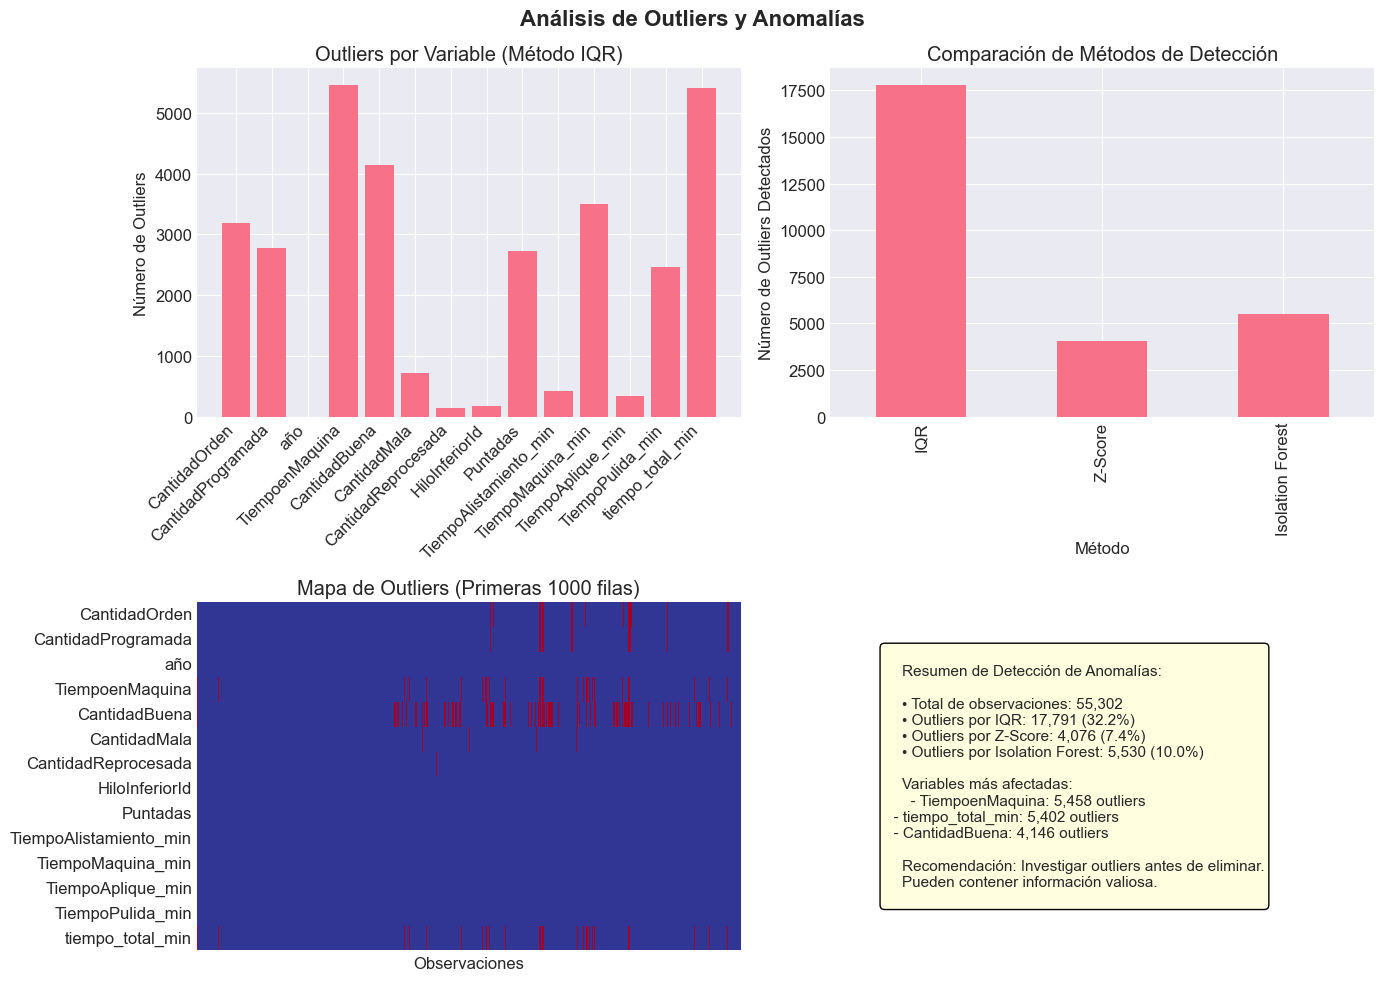

In [1832]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

def detect_outliers(df):
    """Detección de outliers usando múltiples métodos"""
    
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Método 1: IQR
    outliers_iqr = pd.DataFrame()
    for col in numeric_df.columns:
        Q1 = numeric_df[col].quantile(0.25)
        Q3 = numeric_df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((numeric_df[col] < Q1 - 1.5 * IQR) | 
                   (numeric_df[col] > Q3 + 1.5 * IQR))
        outliers_iqr[col] = outliers
    
    # Método 2: Z-Score
    from scipy import stats
    z_scores = np.abs(stats.zscore(numeric_df.fillna(numeric_df.median())))
    outliers_zscore = (z_scores > 3)
    
    # Método 3: Isolation Forest
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df.fillna(numeric_df.median()))
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outliers_iso = iso_forest.fit_predict(scaled_data) == -1
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Outliers por columna (IQR)
    ax1 = axes[0, 0]
    outlier_counts = outliers_iqr.sum()
    ax1.bar(range(len(outlier_counts)), outlier_counts.values)
    ax1.set_xticks(range(len(outlier_counts)))
    ax1.set_xticklabels(outlier_counts.index, rotation=45, ha='right')
    ax1.set_title('Outliers por Variable (Método IQR)')
    ax1.set_ylabel('Número de Outliers')
    
    # Plot 2: Distribución de outliers por método
    ax2 = axes[0, 1]
    methods_comparison = pd.DataFrame({
        'IQR': outliers_iqr.any(axis=1).sum(),
        'Z-Score': outliers_zscore.any(axis=1).sum(),
        'Isolation Forest': outliers_iso.sum()
    }, index=['Outliers'])
    methods_comparison.T.plot(kind='bar', ax=ax2, legend=False)
    ax2.set_title('Comparación de Métodos de Detección')
    ax2.set_ylabel('Número de Outliers Detectados')
    ax2.set_xlabel('Método')
    
    # Plot 3: Heatmap de outliers
    ax3 = axes[1, 0]
    sample_outliers = outliers_iqr.head(1000)
    sns.heatmap(sample_outliers.T, cmap='RdYlBu_r', cbar=False, ax=ax3,
               yticklabels=True, xticklabels=False)
    ax3.set_title('Mapa de Outliers (Primeras 1000 filas)')
    ax3.set_xlabel('Observaciones')
    
    # Plot 4: Resumen estadístico
    ax4 = axes[1, 1]
    ax4.axis('off')
    summary_text = f"""
    Resumen de Detección de Anomalías:
    
    • Total de observaciones: {len(df):,}
    • Outliers por IQR: {outliers_iqr.any(axis=1).sum():,} ({outliers_iqr.any(axis=1).sum()/len(df)*100:.1f}%)
    • Outliers por Z-Score: {outliers_zscore.any(axis=1).sum():,} ({outliers_zscore.any(axis=1).sum()/len(df)*100:.1f}%)
    • Outliers por Isolation Forest: {outliers_iso.sum():,} ({outliers_iso.sum()/len(df)*100:.1f}%)
    
    Variables más afectadas:
    {chr(10).join([f'  - {col}: {count:,} outliers' 
                   for col, count in outlier_counts.nlargest(3).items()])}
    
    Recomendación: Investigar outliers antes de eliminar.
    Pueden contener información valiosa.
    """
    ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes,
            fontsize=11, verticalalignment='center',
            bbox=dict(boxstyle='round', facecolor='lightyellow'))
    
    plt.suptitle('Análisis de Outliers y Anomalías', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return outliers_iqr, outliers_zscore, outliers_iso

outliers_iqr, outliers_zscore, outliers_iso = detect_outliers(df_model)

### 7. Análisis Avanzado (Correlación y Estacionalidad)

In [1833]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55302 entries, 0 to 55489
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Operario                55302 non-null  category      
 1   MaterialIdOrden         55302 non-null  object        
 2   codigoMaterial          55302 non-null  object        
 3   CantidadOrden           55302 non-null  int64         
 4   NombreMaquina           55302 non-null  category      
 5   CantidadProgramada      55302 non-null  int64         
 6   FechaInicio             55302 non-null  datetime64[ns]
 7   FechaFin                55302 non-null  datetime64[ns]
 8   año                     55302 non-null  int64         
 9   TiempoenMaquina         55302 non-null  float64       
 10  CantidadBuena           55302 non-null  int64         
 11  CantidadMala            55302 non-null  int64         
 12  CantidadReprocesada     55302 non-null  int64      

#### 7.1. Correlación Pearson vs Spearman

Comparamos la correlación lineal (Pearson) con la correlación de rango (Spearman) para detectar relaciones no lineales entre las variables numéricas y el target.

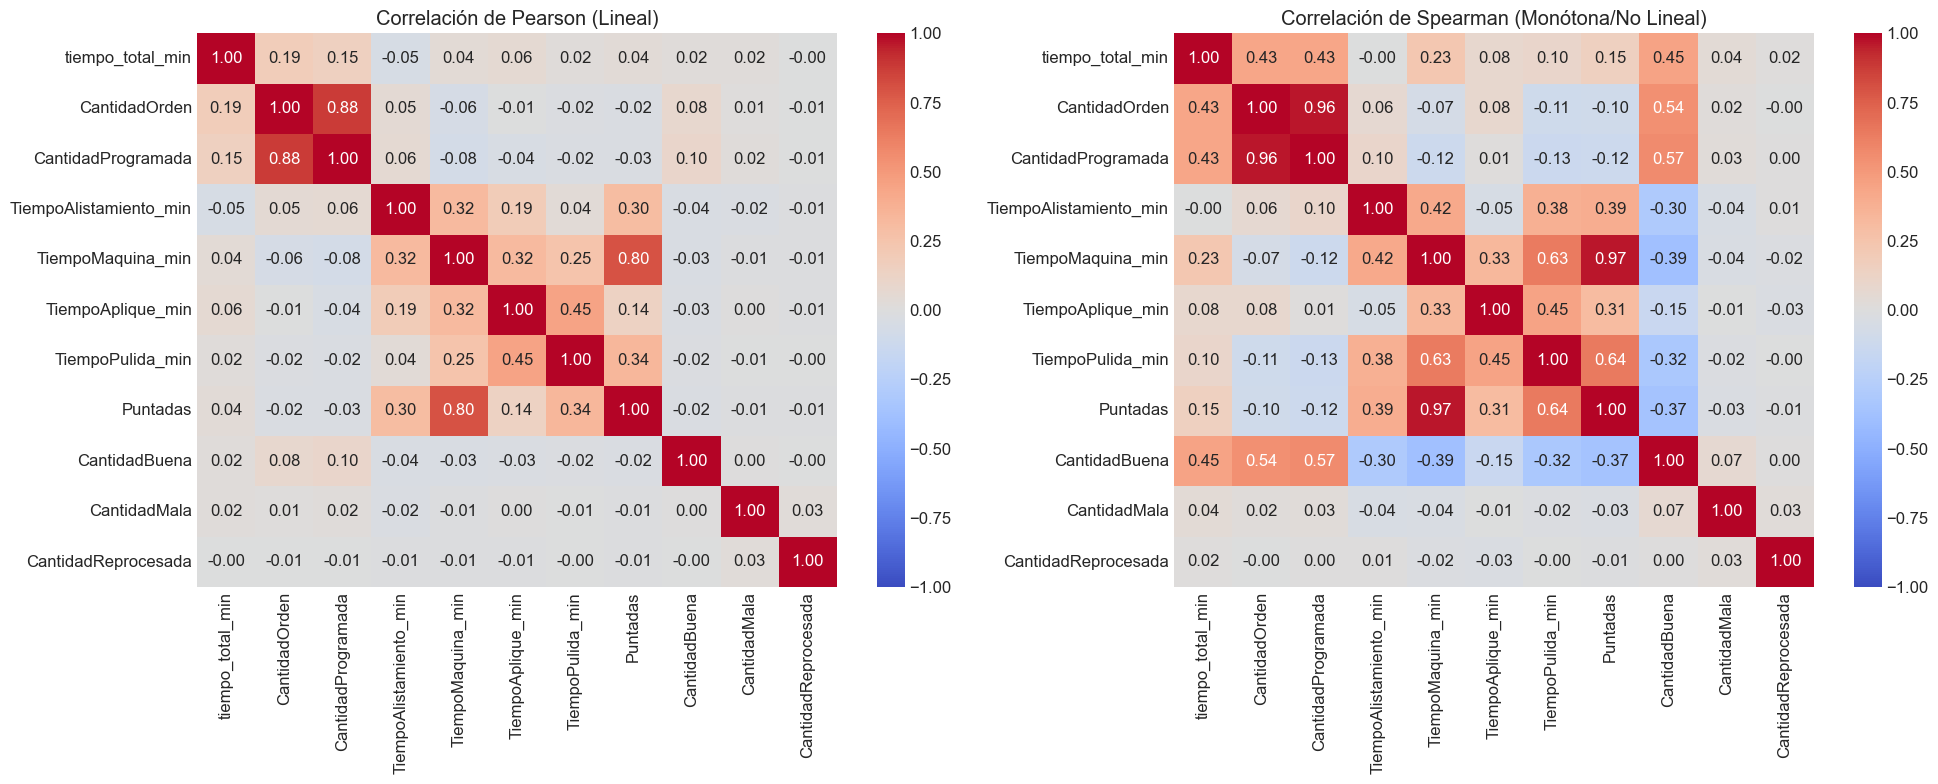

Top Correlaciones Spearman con tiempo_total_min:
tiempo_total_min          1.00
CantidadBuena             0.45
CantidadOrden             0.43
CantidadProgramada        0.43
TiempoMaquina_min         0.23
Puntadas                  0.15
TiempoPulida_min          0.10
TiempoAplique_min         0.08
CantidadMala              0.04
CantidadReprocesada       0.02
TiempoAlistamiento_min   -0.00
Name: tiempo_total_min, dtype: float64


In [1834]:
# Seleccionar variables numéricas relevantes
cols_corr = [
    'tiempo_total_min', 'CantidadOrden', 'CantidadProgramada',
    'TiempoAlistamiento_min', 'TiempoMaquina_min', 'TiempoAplique_min', 
    'TiempoPulida_min', 'Velocidad', 'Presion', 'Temperatura',
    'NumeroApliques', 'Puntadas', 'CantidadBuena', 'CantidadMala', 'CantidadReprocesada'
]
# Filtrar las que existen en el df
cols_corr = [c for c in cols_corr if c in df_model.columns]

# Calcular matrices
corr_pearson = df_model[cols_corr].corr(method='pearson')
corr_spearman = df_model[cols_corr].corr(method='spearman')
# Graficar
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0], fmt=".2f")
axes[0].set_title('Correlación de Pearson (Lineal)')

sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1], fmt=".2f")
axes[1].set_title('Correlación de Spearman (Monótona/No Lineal)')

plt.tight_layout()
plt.show()

# Mostrar top correlaciones con el target
if 'tiempo_total_min' in corr_spearman.columns:
    print("Top Correlaciones Spearman con tiempo_total_min:")
    print(corr_spearman['tiempo_total_min'].sort_values(ascending=False))

#### 7.2. Análisis de Estacionalidad

Evaluamos si existen patrones temporales en el `TiempoenMaquina` (mensuales, semanales u horarios).

C:\Users\Admin\AppData\Local\Temp\ipykernel_5824\3925772210.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ts, x='mes', y='tiempo_total_min', ax=axes[0], palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_5824\3925772210.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ts, x='dia_semana', y='tiempo_total_min', order=order_days, ax=axes[1], palette='magma')
C:\Users\Admin\AppData\Local\Temp\ipykernel_5824\3925772210.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ts, x='hora', y='tiempo_total

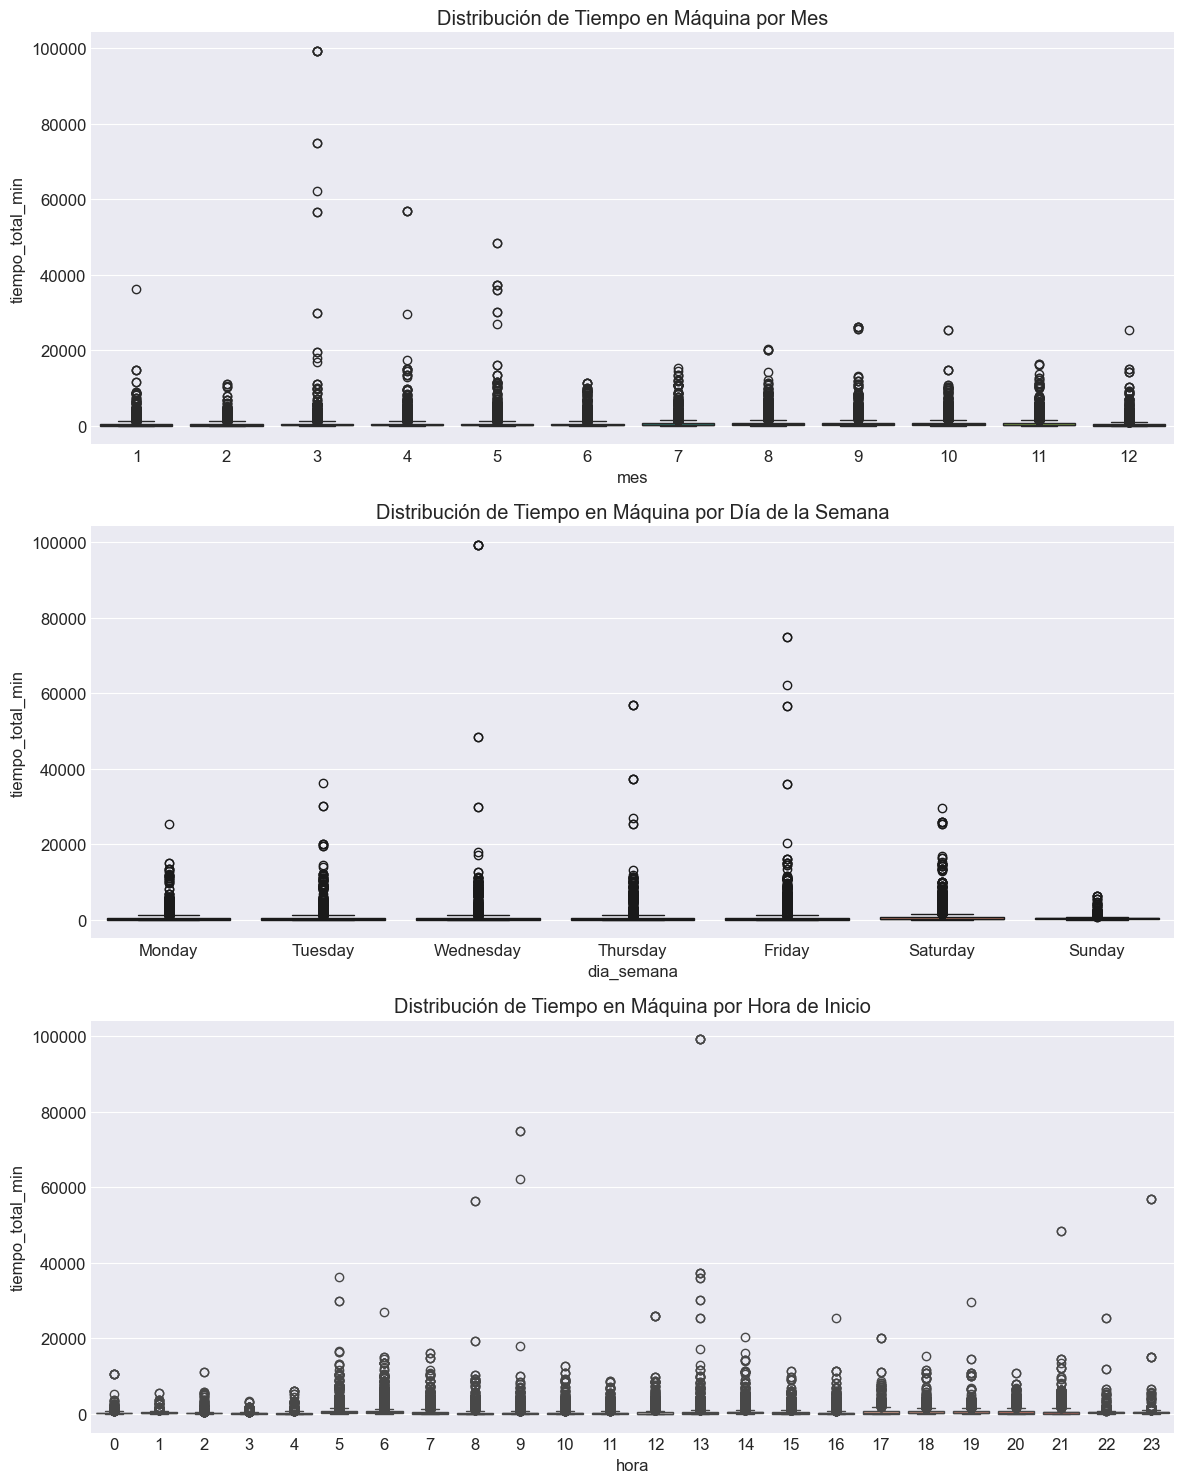

In [1835]:
# Crear columnas temporales
if 'FechaInicio' in df_model.columns:
    df_ts = df_model.copy()
    df_ts['FechaInicio'] = pd.to_datetime(df_ts['FechaInicio'], errors='coerce')
    df_ts = df_ts.dropna(subset=['FechaInicio', 'tiempo_total_min'])
    
    df_ts['mes'] = df_ts['FechaInicio'].dt.month
    df_ts['dia_semana'] = df_ts['FechaInicio'].dt.day_name()
    df_ts['hora'] = df_ts['FechaInicio'].dt.hour
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    
    # Por Mes
    sns.boxplot(data=df_ts, x='mes', y='tiempo_total_min', ax=axes[0], palette='viridis')
    axes[0].set_title('Distribución de Tiempo en Máquina por Mes')
    
    # Por Día de la Semana
    order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    sns.boxplot(data=df_ts, x='dia_semana', y='tiempo_total_min', order=order_days, ax=axes[1], palette='magma')
    axes[1].set_title('Distribución de Tiempo en Máquina por Día de la Semana')
    
    # Por Hora del Día
    sns.boxplot(data=df_ts, x='hora', y='tiempo_total_min', ax=axes[2], palette='coolwarm')
    axes[2].set_title('Distribución de Tiempo en Máquina por Hora de Inicio')
    
    plt.tight_layout()
    plt.show()
else:
    print("No se encuentra la columna 'FechaInicio' para análisis de estacionalidad.")

In [1836]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55302 entries, 0 to 55489
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Operario                55302 non-null  category      
 1   MaterialIdOrden         55302 non-null  object        
 2   codigoMaterial          55302 non-null  object        
 3   CantidadOrden           55302 non-null  int64         
 4   NombreMaquina           55302 non-null  category      
 5   CantidadProgramada      55302 non-null  int64         
 6   FechaInicio             55302 non-null  datetime64[ns]
 7   FechaFin                55302 non-null  datetime64[ns]
 8   año                     55302 non-null  int64         
 9   TiempoenMaquina         55302 non-null  float64       
 10  CantidadBuena           55302 non-null  int64         
 11  CantidadMala            55302 non-null  int64         
 12  CantidadReprocesada     55302 non-null  int64      

In [1837]:
import numpy as np
import pandas as pd

def agregar_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
    # =========================================
    # 0) Imputación de Puntadas + nueva feature
    # =========================================
    if "Puntadas" in df.columns:
        # Imputar Puntadas (si viene vacía)
        df["Puntadas"] = df["Puntadas"].fillna(0)

        # Asegurar CantidadBuena también sin NaN
        if "CantidadBuena" in df.columns:
            df["CantidadBuena"] = df["CantidadBuena"].fillna(0)
        else:
            df["CantidadBuena"] = 0

        # NUEVA FEATURE: puntadas totales por orden
        df["puntadas_totales"] = df["Puntadas"] * df["CantidadBuena"]

    # =========================================
    # 1) Features de FECHA (antes del drop)
    # =========================================
    if "FechaInicio" in df.columns:
        df["FechaInicio_dt"] = pd.to_datetime(df["FechaInicio"], errors="coerce")
        df["dia_semana"] = df["FechaInicio_dt"].dt.dayofweek
        df["mes"] = df["FechaInicio_dt"].dt.month
        df["hora"] = df["FechaInicio_dt"].dt.hour
        df["es_fin_semana"] = df["FechaInicio_dt"].dt.dayofweek.isin([5, 6]).astype(int)

        def clasificar_turno(h):
            if pd.isna(h):
                return "desconocido"
            h = int(h)
            if 6 <= h < 14:
                return "mañana"
            elif 14 <= h < 22:
                return "tarde"
            else:
                return "noche"

        df["turno"] = df["hora"].apply(clasificar_turno)

    return df


In [1838]:
# Lista de columnas a eliminar

df_model = agregar_features(df_model)

cols_to_drop = [
    "TiempoAlistamiento",
    "TiempoMaquina",
    "TiempoAplique",
    "TiempoPulida",
    "TiempoAlistamiento_min",
    "TiempoMaquina_min",
    "TiempoAplique_min",
    "TiempoPulida_min",
    "TiempoenMaquina",
    "FechaInicio",
    "FechaFin",
    "MaterialIdOrden",
    "HiloInferiorId",
    "CantidadMala",
    "CantidadReprocesada",
    "CantidadProgramada",
    "CantidadOrden",
    "FechaInicio_dt",
]

# Eliminarlas del dataframe
df_model = df_model.drop(columns=cols_to_drop, errors="ignore")

print("Columnas eliminadas:")
print(cols_to_drop)
print("\nNueva forma del dataset:", df_model.shape)
# Convertir explícitamente a category
df_model['codigoMaterial'] = df_model['codigoMaterial'].astype('category')

df_model

Columnas eliminadas:
['TiempoAlistamiento', 'TiempoMaquina', 'TiempoAplique', 'TiempoPulida', 'TiempoAlistamiento_min', 'TiempoMaquina_min', 'TiempoAplique_min', 'TiempoPulida_min', 'TiempoenMaquina', 'FechaInicio', 'FechaFin', 'MaterialIdOrden', 'HiloInferiorId', 'CantidadMala', 'CantidadReprocesada', 'CantidadProgramada', 'CantidadOrden', 'FechaInicio_dt']

Nueva forma del dataset: (55302, 14)


,Operario,codigoMaterial,NombreMaquina,año,CantidadBuena,PuntoPlantilla,Puntadas,tiempo_total_min,puntadas_totales,dia_semana,mes,hora,es_fin_semana,turno
0,Edward Dario Pulgarin Paniagua,U53554,Bordadora 12,2021,162,1,1735.00,380.00,281070.00,1,6,11,0,mañana
1,Edward Dario Pulgarin Paniagua,U53554,Bordadora 12,2021,471,1,1735.00,6910.00,817185.00,4,6,11,0,mañana
2,Edwin Alonso Jaramillo Castaño,U53554,Bordadora 12,2021,5,1,1735.00,6910.00,8675.00,4,6,11,0,mañana
3,Francisco Nicolas Parra Acevedo,U53554,Bordadora 05,2021,10,1,1735.00,47.00,17350.00,0,3,10,0,mañana
4,Gloria Elsy Jimenez Giraldo,U53554,Bordadora 14,2020,13,1,1735.00,27.00,22555.00,1,7,21,0,tarde
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55485,Doralba Maria Amariles Madrigal,U90747,Bordadora 06,2025,6,0,0.00,33.00,0.00,2,10,15,0,tarde
55486,Ignacio Aristizabal Borja,U90747,Bordadora 06,2025,34,0,0.00,1203.00,0.00,3,10,12,0,mañana
55487,Doralba Maria Amariles Madrigal,U90750,Bordadora 06,2025,20,0,0.00,51.72,0.00,1,10,14,0,tarde
55488,Iliana Del Carmen Gonzalez Duran,U90774,Bordadora 17,2025,17,0,0.00,76.00,0.00,4,10,3,0,noche


In [1839]:

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

def create_train_test_split(df, test_size=0.2, stratify_column='tiempo_total_min'):
    """
    Crea conjuntos de entrenamiento y prueba estratificados para tiempo_total_min.
    """
    # 1. Definir bins dinámicos basados en la distribución real de tus datos
    # Usamos [-inf, Q20, Q40, Q60, Q80, inf] para asegurar 5 grupos equilibrados
    bins = [-np.inf] + df[stratify_column].quantile([0.2, 0.4, 0.6, 0.8]).tolist() + [np.inf]
    
    # Crear columna temporal de categorías
    # Copiamos para evitar warnings
    df_temp = df.copy()
    df_temp['stratify_cat'] = pd.cut(df_temp[stratify_column],
                                     bins=bins,
                                     labels=[1, 2, 3, 4, 5])
    
    # 2. División estratificada
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    
    for train_idx, test_idx in splitter.split(df_temp, df_temp['stratify_cat']):
        train_set = df_temp.iloc[train_idx].copy()
        test_set = df_temp.iloc[test_idx].copy()
    
    # 3. Verificar proporciones (Tu código de validación)
    print("📊 Verificación de Estratificación:")
    print("=" * 50)
    original_props = df_temp['stratify_cat'].value_counts(normalize=True).sort_index()
    train_props = train_set['stratify_cat'].value_counts(normalize=True).sort_index()
    test_props = test_set['stratify_cat'].value_counts(normalize=True).sort_index()
    
    comparison = pd.DataFrame({
        'Original': original_props,
        'Train': train_props,
        'Test': test_props
    })
    # Calculamos el error relativo
    comparison['Train_Error_%'] = (comparison['Train'] / comparison['Original'] - 1) * 100
    comparison['Test_Error_%'] = (comparison['Test'] / comparison['Original'] - 1) * 100
    
    # Mostramos tabla redondeada
    print(comparison.round(4)) # 4 decimales para ver mejor la precisión
    
    # 4. Limpieza final: eliminar la columna auxiliar 'stratify_cat'
    for set_ in (train_set, test_set):
        set_.drop('stratify_cat', axis=1, inplace=True)

    print(f"\nConjuntos creados exitosamente:")
    print(f"   • Entrenamiento: {len(train_set):,} filas")
    print(f"   • Prueba: {len(test_set):,} filas")
    
    return train_set, test_set

# --- Ejecución con tu df_model ---
# Asegúrate de haber hecho la limpieza previa (el drop del '11CM')
strat_train_set, strat_test_set = create_train_test_split(df_model, test_size=0.2, stratify_column='tiempo_total_min')

📊 Verificación de Estratificación:
              Original  Train  Test  Train_Error_%  Test_Error_%
stratify_cat                                                    
1                 0.20   0.20  0.20          -0.00          0.01
2                 0.20   0.20  0.20          -0.00          0.01
3                 0.20   0.20  0.20           0.00         -0.01
4                 0.20   0.20  0.20           0.00         -0.01
5                 0.20   0.20  0.20           0.00         -0.01

Conjuntos creados exitosamente:
   • Entrenamiento: 44,241 filas
   • Prueba: 11,061 filas


In [1840]:
import pandas as pd
import numpy as np
import re

def aplicar_codificacion(train_df, test_df, target_col="tiempo_total_min", alpha=5):
    """
    Aplica:
      1) Target encoding con smoothing a varias columnas categóricas
         (Operario, NombreMaquina, codigoMaterial).
      2) One-hot encoding a turno (Mañana/Tarde/Noche).
      3) One-hot encoding a PuntoPlantilla.
      4) Imputación de Puntadas.
      5) Separación X / y.
    """

    # Copias por seguridad
    train_df = train_df.copy()
    test_df = test_df.copy()

    # ============================================================
    # 1) Columnas a codificar por TARGET ENCODING (SIN turno)
    # ============================================================
    te_cols = [
        "Operario",
        "NombreMaquina",
        "codigoMaterial",
    ]

    # Asegurar string en columnas TE
    for col in te_cols:
        if col in train_df.columns:
            train_df[col] = train_df[col].astype(str)
        if col in test_df.columns:
            test_df[col] = test_df[col].astype(str)

    # ============================================================
    # 2) TARGET ENCODING CON SMOOTHING
    # ============================================================
    y_train = train_df[target_col].copy()
    y_test = test_df[target_col].copy()

    global_mean = y_train.mean()
    enc_maps = {}

    for col in te_cols:
        if col not in train_df.columns:
            continue

        stats = train_df.groupby(col)[target_col].agg(["mean", "count"])
        stats["enc"] = (stats["mean"] * stats["count"] + global_mean * alpha) / (stats["count"] + alpha)

        enc_maps[col] = stats["enc"]

        # Aplicar a train y test
        train_df[f"{col}_encoded"] = train_df[col].map(enc_maps[col]).fillna(global_mean)
        if col in test_df.columns:
            test_df[f"{col}_encoded"] = test_df[col].map(enc_maps[col]).fillna(global_mean)
        else:
            test_df[f"{col}_encoded"] = global_mean

    # 🔹 Ahora SÍ borramos las columnas originales que ya tienen versión _encoded
    train_df = train_df.drop(columns=te_cols, errors="ignore")
    test_df = test_df.drop(columns=te_cols, errors="ignore")

    # ============================================================
    # 3) ONE-HOT ENCODING DE TURNO (NO target encoding)
    # ============================================================
    if "turno" in train_df.columns:
        train_df["turno"] = train_df["turno"].astype(str).str.strip()
    if "turno" in test_df.columns:
        test_df["turno"] = test_df["turno"].astype(str).str.strip()

    if "turno" in train_df.columns:
        train_df = pd.get_dummies(train_df, columns=["turno"], prefix="turno", drop_first=True)
    if "turno" in test_df.columns:
        test_df = pd.get_dummies(test_df, columns=["turno"], prefix="turno", drop_first=True)

    # Alinear columnas de turno
    turno_cols = sorted(
        set(
            [c for c in train_df.columns if c.startswith("turno_")] +
            [c for c in test_df.columns if c.startswith("turno_")]
        )
    )
    for df_ in (train_df, test_df):
        for c in turno_cols:
            if c not in df_.columns:
                df_[c] = 0

    # 4) ONE-HOT ENCODING DE PUNTO PLANTILLA
    drop_value = 'dejar arriba hacia abajo 11cm'

    if "PuntoPlantilla" in train_df.columns:
        train_df['PuntoPlantilla'] = train_df['PuntoPlantilla'].astype(str).str.strip()
    if "PuntoPlantilla" in test_df.columns:
        test_df['PuntoPlantilla'] = test_df['PuntoPlantilla'].astype(str).str.strip()

    # Construir máscaras de filas que SE QUEDAN
    if "PuntoPlantilla" in train_df.columns:
        mask_train = train_df['PuntoPlantilla'].str.lower() != drop_value
    else:
        mask_train = pd.Series(True, index=train_df.index)

    if "PuntoPlantilla" in test_df.columns:
        mask_test = test_df['PuntoPlantilla'].str.lower() != drop_value
    else:
        mask_test = pd.Series(True, index=test_df.index)

    # Aplicar el MISMO filtro a df y al target
    train_df = train_df.loc[mask_train].copy()
    test_df = test_df.loc[mask_test].copy()
    y_train = y_train.loc[mask_train].copy()
    y_test = y_test.loc[mask_test].copy()

    # One-hot PuntoPlantilla
    if "PuntoPlantilla" in train_df.columns:
        train_df = pd.get_dummies(train_df, columns=['PuntoPlantilla'], prefix='Plantilla', drop_first=True)
    if "PuntoPlantilla" in test_df.columns:
        test_df = pd.get_dummies(test_df, columns=['PuntoPlantilla'], prefix='Plantilla', drop_first=True)

    # ============================================================
    # 5) IMPUTACIÓN PUNTADAS
    # ============================================================
    if "Puntadas" in train_df.columns:
        train_df["Puntadas"] = train_df["Puntadas"].fillna(0)
    if "Puntadas" in test_df.columns:
        test_df["Puntadas"] = test_df["Puntadas"].fillna(0)

    # ============================================================
    # 6) ORDENAR COLUMNAS ESTRUCTURADAMENTE
    # ============================================================
    train_df = train_df.reindex(sorted(train_df.columns), axis=1)
    test_df = test_df.reindex(sorted(test_df.columns), axis=1)

    # ============================================================
    # 7) SEPARAR X E Y
    # ============================================================
    X_train = train_df.drop(columns=[target_col])
    X_test = test_df.drop(columns=[target_col])

    return X_train, y_train, X_test, y_test, enc_maps





In [1841]:
X_train, y_train, X_test, y_test, enc_maps = aplicar_codificacion(
    strat_train_set,
    strat_test_set,
    target_col="tiempo_total_min",
    alpha=5
)

In [1842]:
# ✅ Ya no tiene tiempo_total_min (se separó en celda 53)
prod_labels = y_train.copy()
prod_prepared = X_train.copy()

prod_num = prod_prepared.select_dtypes(include=[np.number])
prod_cat = prod_prepared.select_dtypes(include=['object'])

print(f"📊 Preparación de datos:")
print(f"   • Características numéricas: {prod_num.shape[1]}")
print(f"   • Características categóricas: {prod_cat.shape[1]}")
print(f"   • Total de características: {prod_prepared.shape[1]}")
print(f"   • Muestras de entrenamiento: {len(prod_prepared):,}")

prod_prepared

📊 Preparación de datos:
   • Características numéricas: 11
   • Características categóricas: 0
   • Total de características: 14
   • Muestras de entrenamiento: 44,233


,CantidadBuena,NombreMaquina_encoded,Operario_encoded,Plantilla_1,Puntadas,año,codigoMaterial_encoded,dia_semana,es_fin_semana,hora,mes,puntadas_totales,turno_noche,turno_tarde
40830,66,300.90,277.95,False,0.00,2024,284.24,3,0,4,8,0.00,True,False
19645,90,564.97,361.59,False,442.00,2024,320.88,3,0,19,7,39780.00,False,True
10787,240,448.56,384.66,False,2003.00,2021,582.26,2,0,6,2,480720.00,False,False
20164,416,652.92,603.34,True,860.00,2022,277.13,0,0,15,1,357760.00,False,True
55024,34,843.38,418.02,False,0.00,2025,1390.19,0,0,20,10,0.00,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7557,192,579.33,463.19,False,1848.00,2020,414.73,1,0,5,9,354816.00,True,False
36584,58,559.96,1005.75,False,0.00,2023,445.80,0,0,18,11,0.00,False,True
51250,58,579.33,618.09,False,0.00,2025,1080.08,4,0,13,8,0.00,False,False
54653,16,506.22,472.37,False,0.00,2025,453.43,2,0,19,7,0.00,False,True


Columnas usadas en la correlación:
['CantidadBuena', 'NombreMaquina_encoded', 'Operario_encoded', 'Plantilla_1', 'Puntadas', 'año', 'codigoMaterial_encoded', 'dia_semana', 'es_fin_semana', 'hora', 'mes', 'puntadas_totales', 'turno_noche', 'turno_tarde', 'tiempo_total_min']


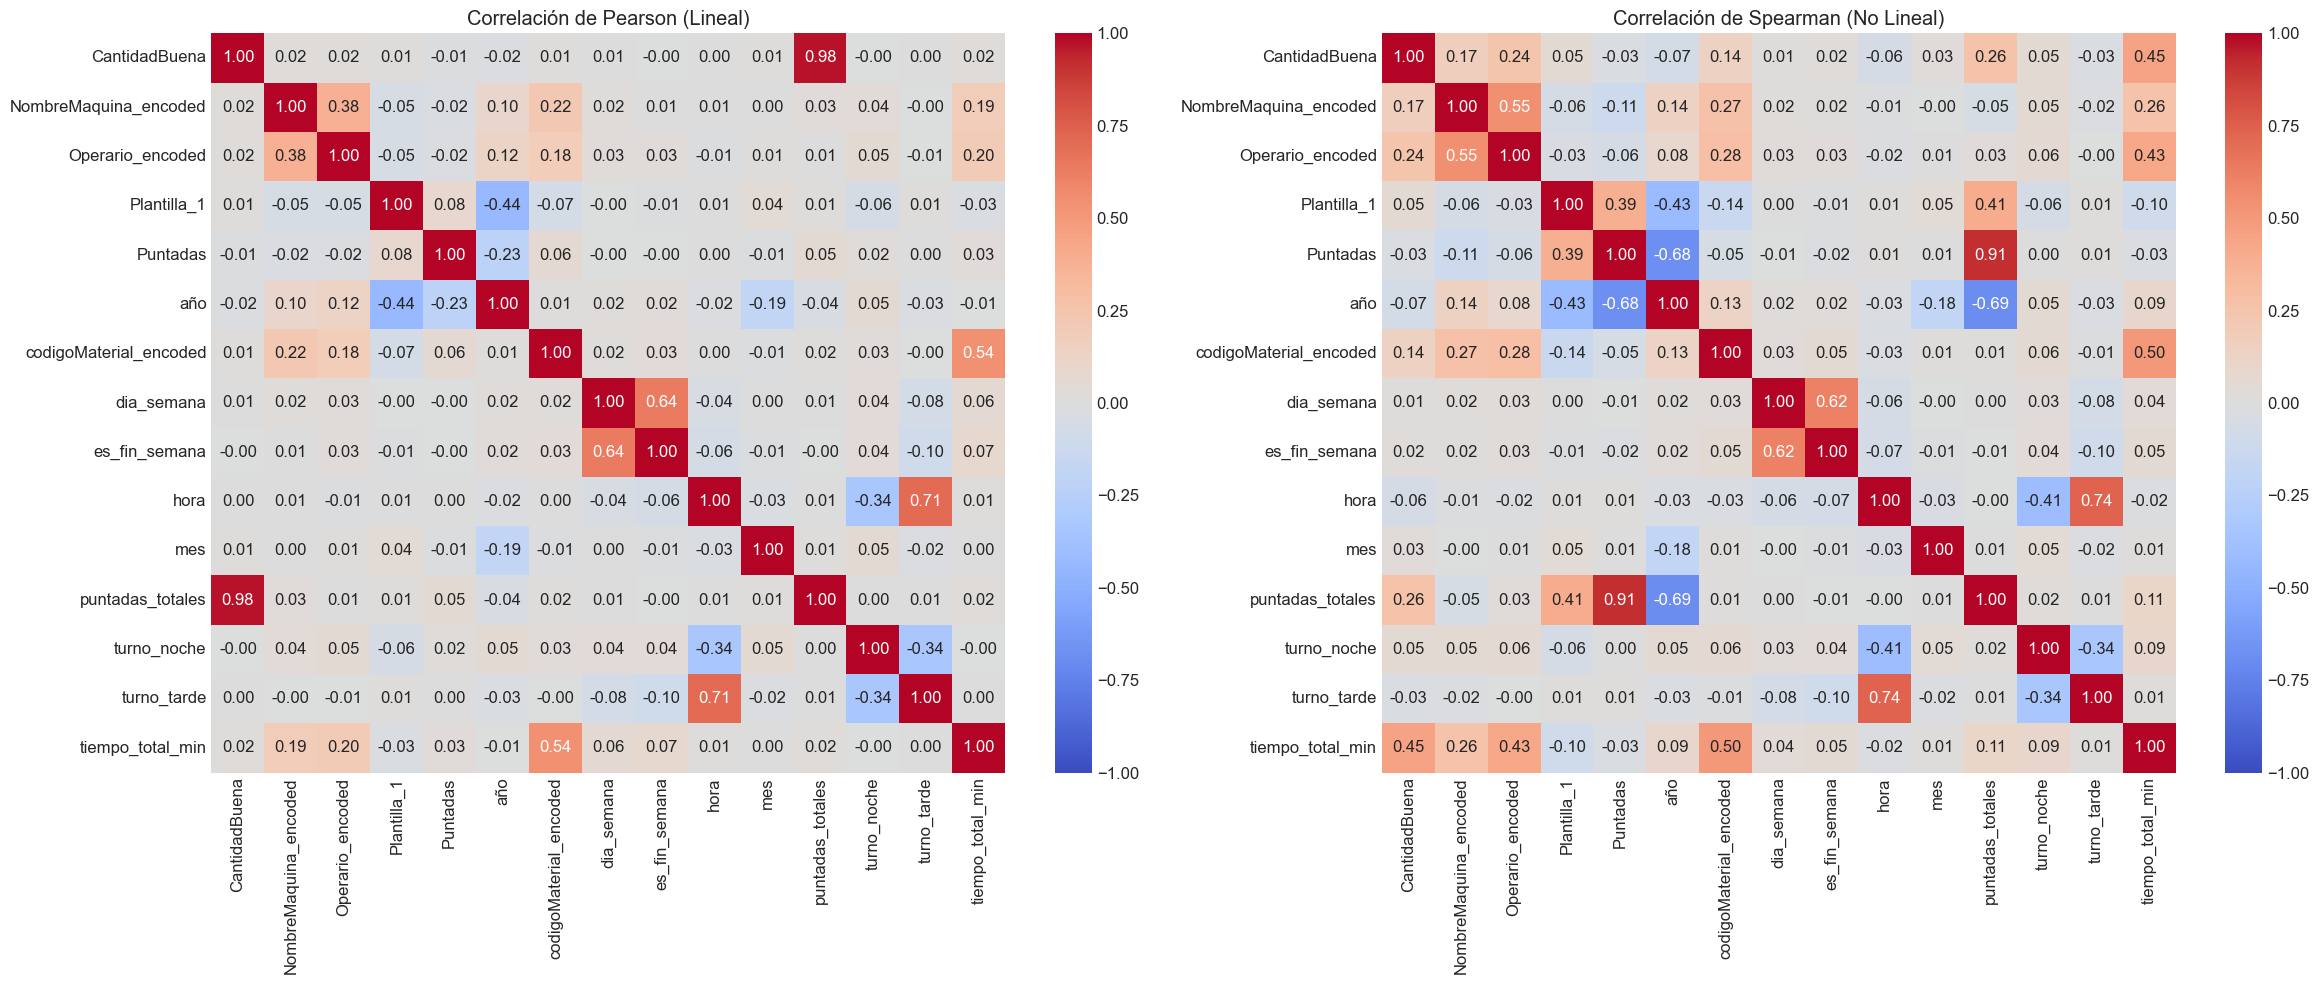

In [1843]:
# ✅ 1. Reconstruir un DataFrame con features + target
df_corr = prod_prepared.copy()              # X_train ya codificado
df_corr["tiempo_total_min"] = prod_labels.values  # y_train

# ✅ 2. Usar TODAS las columnas numéricas + bool (incluye encoded, dummies, etc.)
num_cols = df_corr.select_dtypes(include=[np.number, "bool"]).columns.tolist()
print("Columnas usadas en la correlación:")
print(num_cols)

# Convertir bool → float para que todo sea homogéneo
df_corr[num_cols] = df_corr[num_cols].astype(float)

# ✅ 3. Calcular matrices de correlación
corr_pearson = df_corr[num_cols].corr(method='pearson')
corr_spearman = df_corr[num_cols].corr(method='spearman')

# ✅ 4. Graficar heatmaps con anotaciones
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

sns.heatmap(
    corr_pearson,
    annot=True,        # 👈 ahora sí muestra el valor
    fmt=".2f",         # 2 decimales
    cmap='coolwarm',
    vmin=-1, vmax=1,
    ax=axes[0]
)
axes[0].set_title('Correlación de Pearson (Lineal)')

sns.heatmap(
    corr_spearman,
    annot=True,        # 👈 también aquí
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1, vmax=1,
    ax=axes[1]
)
axes[1].set_title('Correlación de Spearman (No Lineal)')

plt.tight_layout()
plt.show()


In [1844]:
# Instalar paquetes necesarios (si no están instalados)
import subprocess
import sys
# Importar modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Definir modelos a evaluar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': CatBoostRegressor(iterations=100, verbose=0, random_state=42),

}

print("\n✅ Modelos importados y definidos:")
print(f"   • Total de modelos: {len(models)}")
print(f"   • Modelos: {list(models.keys())}")
print(f"\n📊 Dimensiones de datos:")
print(f"   X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"   y_train: {y_train.shape} | y_test: {y_test.shape}")


✅ Modelos importados y definidos:
   • Total de modelos: 10
   • Modelos: ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Random Forest', 'Extra Trees', 'Gradient Boosting', 'XGBoost', 'LightGBM', 'CatBoost']

📊 Dimensiones de datos:
   X_train: (44233, 14) | X_test: (11059, 14)
   y_train: (44233,) | y_test: (11059,)


In [1845]:

# Función para evaluar modelos
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Evalúa un modelo en train y test, calcula métricas.
    """
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Métricas en train
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Métricas en test
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    # MAPE (Mean Absolute Percentage Error)
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    
    results = {
        'Modelo': model_name,
        'RMSE_train': rmse_train,
        'RMSE_test': rmse_test,
        'MAE_train': mae_train,
        'MAE_test': mae_test,
        'R²_train': r2_train,
        'R²_test': r2_test,
        'MAPE_%': mape_test,
        'Overfitting': r2_train - r2_test  # Diferencia positiva = overfitting
    }
    
    return results, y_pred_test

print("✅ Función evaluate_model definida correctamente")

✅ Función evaluate_model definida correctamente


In [1846]:
# Entrenar y evaluar cada modelo
results_list = []

print(" Entrenando modelos...")
print("=" * 70)

for name, model in models.items():
    print(f"  {name:25s}", end="", flush=True)
    
    try:
        # Entrenar modelo
        model.fit(X_train, y_train)
        
        # Evaluar modelo
        results, predictions = evaluate_model(model, X_train, y_train, X_test, y_test, name)
        results_list.append(results)
        
        print(f" R² Test: {results['R²_test']:7.4f} | RMSE: {results['RMSE_test']:8.2f}")
    
    except Exception as e:
        print(f" Error: {str(e)[:40]}")
        continue

# Crear DataFrame con resultados
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('R²_test', ascending=False)

print("\n" + "=" * 70)
print("📊 COMPARACIÓN DE MODELOS (Ordenados por R² en Test)")
print("=" * 70)

# Mostrar tabla con colores
display(results_df[['Modelo', 'R²_train', 'R²_test', 'RMSE_test', 'MAE_test', 'MAPE_%', 'Overfitting']].style
    .format({
        'R²_train': '{:.4f}',
        'R²_test': '{:.4f}',
        'RMSE_test': '{:.2f}',
        'MAE_test': '{:.2f}',
        'MAPE_%': '{:.2f}',
        'Overfitting': '{:.4f}'
    })
    .background_gradient(subset=['R²_test'], cmap='RdYlGn', vmin=0, vmax=1)
    .background_gradient(subset=['RMSE_test', 'MAE_test'], cmap='RdYlGn_r')
)

# Resumen
print(f"\nMEJOR MODELO: {results_df.iloc[0]['Modelo']}")
print(f"   R² Test: {results_df.iloc[0]['R²_test']:.4f}")
print(f"   RMSE: {results_df.iloc[0]['RMSE_test']:.2f}")
print(f"   MAE: {results_df.iloc[0]['MAE_test']:.2f}")
print(f"   MAPE: {results_df.iloc[0]['MAPE_%']:.2f}%")


top2_model_names = results_df.head(2)['Modelo'].tolist()

 Entrenando modelos...
  Linear Regression         R² Test: -0.0473 | RMSE:  1204.42
  Ridge Regression          R² Test: -0.0473 | RMSE:  1204.42
  Lasso Regression          R² Test: -0.0473 | RMSE:  1204.41
  Elastic Net               R² Test: -0.0479 | RMSE:  1204.75
  Random Forest             R² Test:  0.1039 | RMSE:  1114.09
  Extra Trees               R² Test:  0.4421 | RMSE:   879.06
  Gradient Boosting         R² Test:  0.1581 | RMSE:  1079.87
  XGBoost                   R² Test:  0.1440 | RMSE:  1088.86
  LightGBM                  R² Test:  0.2121 | RMSE:  1044.69
  CatBoost                  R² Test:  0.1771 | RMSE:  1067.60

📊 COMPARACIÓN DE MODELOS (Ordenados por R² en Test)


,Modelo,R²_train,R²_test,RMSE_test,MAE_test,MAPE_%,Overfitting
5,Extra Trees,1.0000,0.4421,879.06,367.69,inf,0.5579
8,LightGBM,0.7194,0.2121,1044.69,421.19,inf,0.5073
9,CatBoost,0.8350,0.1771,1067.60,424.99,inf,0.6578
6,Gradient Boosting,0.6938,0.1581,1079.87,454.78,inf,0.5357
7,XGBoost,0.8227,0.1440,1088.86,413.47,inf,0.6786
4,Random Forest,0.9353,0.1039,1114.09,404.55,inf,0.8314
2,Lasso Regression,0.3109,-0.0473,1204.41,544.66,inf,0.3582
0,Linear Regression,0.3109,-0.0473,1204.42,544.71,inf,0.3582
1,Ridge Regression,0.3109,-0.0473,1204.42,544.71,inf,0.3582
3,Elastic Net,0.3107,-0.0479,1204.75,543.18,inf,0.3586



MEJOR MODELO: Extra Trees
   R² Test: 0.4421
   RMSE: 879.06
   MAE: 367.69
   MAPE: inf%


## analisis de importancia de caracteristicas



In [1847]:
def analyze_feature_importance(model, feature_names, top_n=20, title='Análisis de Importancia de Características'):
    """Analiza y visualiza la importancia de características de forma robusta."""
    # 1) Extraer importancias
    importances = None
    if hasattr(model, 'feature_importances_'):
        importances = np.asarray(model.feature_importances_, dtype=float)
    elif hasattr(model, 'coef_'):
        coef_ = np.asarray(model.coef_, dtype=float)
        # Multi-clase: promedio del valor absoluto por columna
        importances = np.mean(np.abs(coef_), axis=0) if coef_.ndim > 1 else np.abs(coef_)
    else:
        print("⚠️ El modelo no expone ni 'feature_importances_' ni 'coef_'.")
        return None

    # 2) Validar y alinear nombres de features
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(len(importances))]
    else:
        feature_names = list(feature_names)
        if len(feature_names) != len(importances):
            print(f"⚠️ Largo de 'feature_names' ({len(feature_names)}) ≠ largo de importancias ({len(importances)}). "
                  "Se generarán nombres genéricos.")
            feature_names = [f'Feature_{i}' for i in range(len(importances))]

    # 3) Armar DataFrame ordenado
    order = np.argsort(importances)[::-1]
    importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in order],
        'Importance': importances[order]
    })

    # 4) Limitar a top_k existente para el gráfico de barras
    top_k = min(top_n, len(importance_df))
    top_df = importance_df.head(top_k)

    # 5) Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Barras horizontales (usa posiciones 0..top_k-1)
    y_pos = np.arange(top_k)
    ax1.barh(y_pos, top_df['Importance'].values)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_df['Feature'].values)
    ax1.set_xlabel('Importancia')
    ax1.set_title(f'Top {top_k} características')
    ax1.invert_yaxis()

    # Gráfico de torta (usa hasta 10 o menos si no hay tantas)
    pie_k = min(10, len(importance_df))
    pie_df = importance_df.head(pie_k)
    other_importance = importance_df.iloc[pie_k:]['Importance'].sum()

    pie_data = pie_df['Importance'].tolist()
    pie_labels = pie_df['Feature'].tolist()
    if other_importance > 0:
        pie_data.append(other_importance)
        pie_labels.append('Otras')

    # Evitar error si todo es cero
    if np.sum(pie_data) == 0:
        ax2.text(0.5, 0.5, 'Sin variación en importancias', ha='center', va='center')
        ax2.axis('off')
    else:
        ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%')
        ax2.set_title(f'Distribución de Importancia (Top {pie_k})')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

    return importance_df



===== Importancia de características para: Extra Trees =====


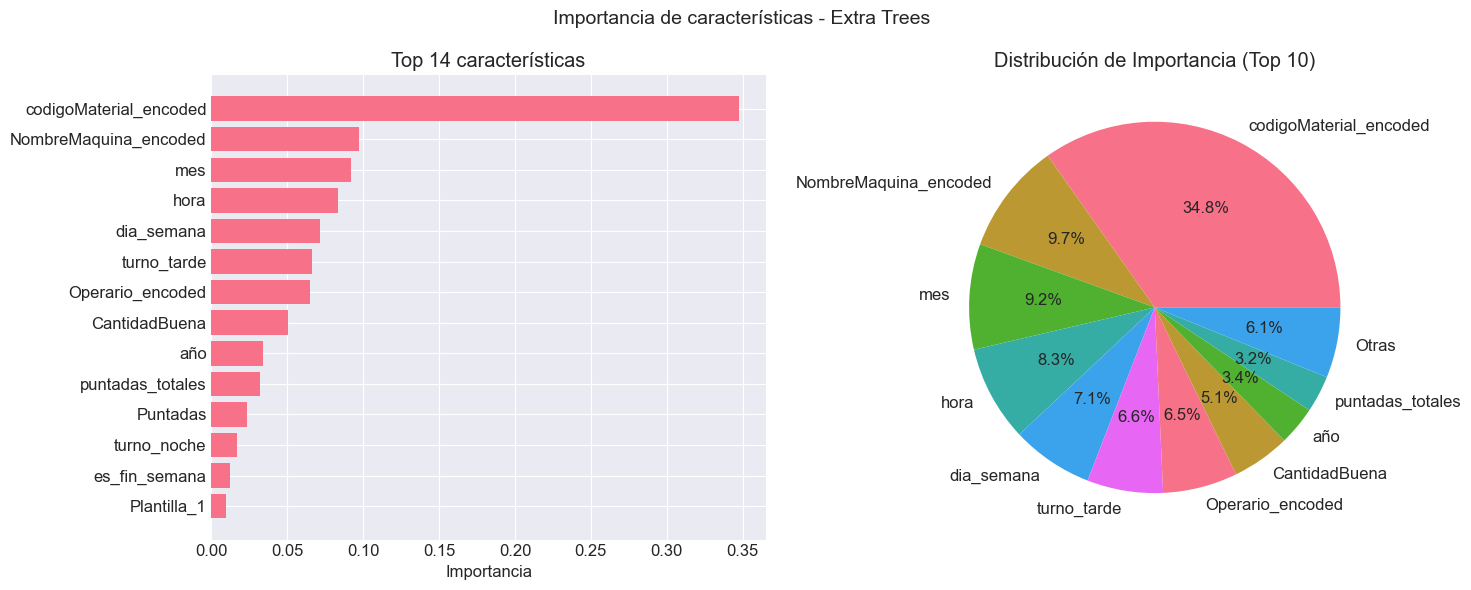


📊 TOP 10 características más importantes:


,Feature,Importance
0,codigoMaterial_encoded,0.35
1,NombreMaquina_encoded,0.10
2,mes,0.09
3,hora,0.08
4,dia_semana,0.07
5,turno_tarde,0.07
6,Operario_encoded,0.07
7,CantidadBuena,0.05
8,año,0.03
9,puntadas_totales,0.03



===== Importancia de características para: LightGBM =====


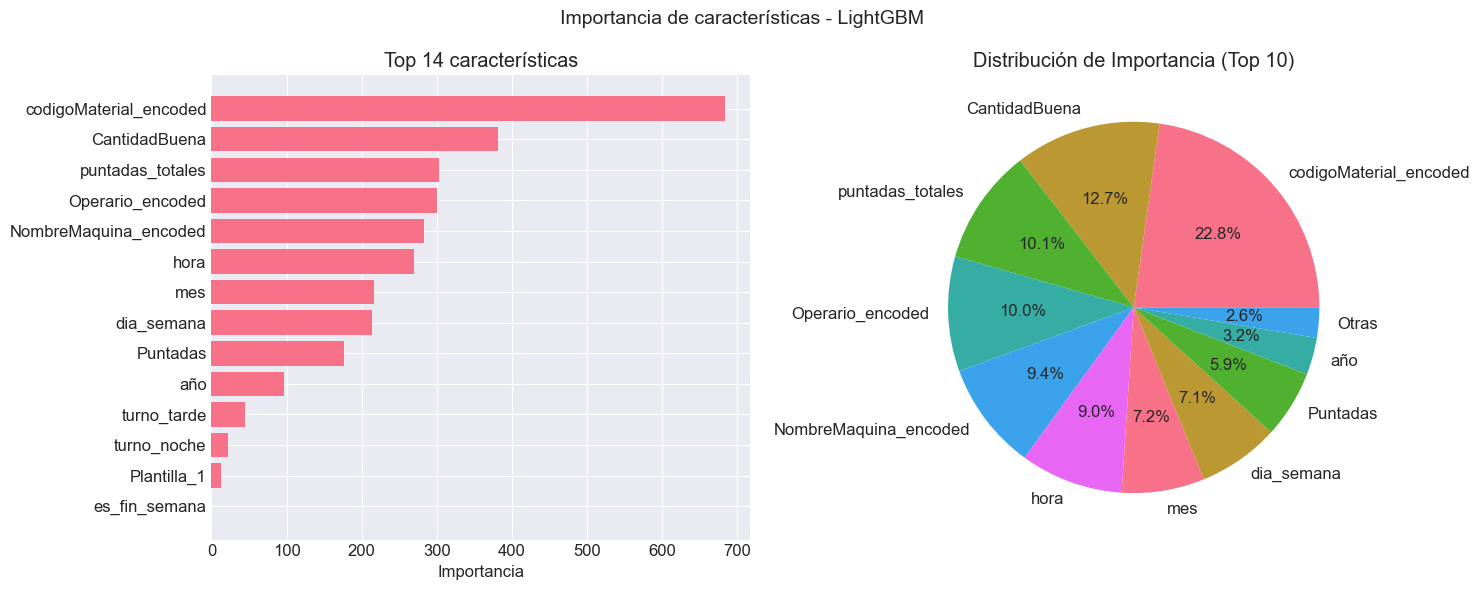


📊 TOP 10 características más importantes:


,Feature,Importance
0,codigoMaterial_encoded,683.00
1,CantidadBuena,381.00
2,puntadas_totales,303.00
3,Operario_encoded,300.00
4,NombreMaquina_encoded,283.00
5,hora,269.00
6,mes,216.00
7,dia_semana,213.00
8,Puntadas,176.00
9,año,97.00


In [1848]:
feature_names = X_train.columns
importances_dict = {}

for model_name in top2_model_names:
    # OJO: el nombre en results_df['Modelo'] debe coincidir
    # con la llave en el dict 'models'
    model = models[model_name]

    print(f"\n===== Importancia de características para: {model_name} =====")
    imp_df = analyze_feature_importance(
        model,
        feature_names,
        top_n=20,
        title=f"Importancia de características - {model_name}"
    )
    importances_dict[model_name] = imp_df

    if imp_df is not None:
        print("\n📊 TOP 10 características más importantes:")
        display(imp_df.head(10))

In [1849]:
from scipy import stats
import matplotlib.pyplot as plt

def analyze_residuals(y_true, y_pred):
    """Análisis completo de residuos"""
    
    residuals = y_true - y_pred
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Residuos vs Predicciones
    ax1 = axes[0, 0]
    ax1.scatter(y_pred, residuals, alpha=0.3, s=10)
    ax1.axhline(y=0, color='red', linestyle='--')
    ax1.set_xlabel('Valores Predichos')
    ax1.set_ylabel('Residuos')
    ax1.set_title('Residuos vs Predicciones')
    ax1.grid(True, alpha=0.3)
    
    # 2. Distribución de residuos
    ax2 = axes[0, 1]
    ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    ax2.axvline(x=0, color='red', linestyle='--')
    ax2.set_xlabel('Residuos')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title('Distribución de Residuos')
    ax2.grid(True, alpha=0.3)
    
    # 3. Q-Q Plot
    ax3 = axes[0, 2]
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot de Residuos')
    ax3.grid(True, alpha=0.3)
    
    # 4. Valores reales vs predichos
    ax4 = axes[1, 0]
    ax4.scatter(y_true, y_pred, alpha=0.3, s=10)
    ax4.plot([y_true.min(), y_true.max()], 
             [y_true.min(), y_true.max()], 
             'r--', lw=2)
    ax4.set_xlabel('Valores Reales')
    ax4.set_ylabel('Valores Predichos')
    ax4.set_title('Reales vs Predichos')
    ax4.grid(True, alpha=0.3)
    
    # 5. Residuos estandarizados
    ax5 = axes[1, 1]
    if residuals.std() > 0:
        standardized_residuals = residuals / residuals.std()
    else:
        standardized_residuals = residuals
    
    ax5.scatter(y_pred, standardized_residuals, alpha=0.3, s=10)
    ax5.axhline(y=0, color='red', linestyle='--')
    ax5.axhline(y=2, color='orange', linestyle='--', alpha=0.5)
    ax5.axhline(y=-2, color='orange', linestyle='--', alpha=0.5)
    ax5.set_xlabel('Valores Predichos')
    ax5.set_ylabel('Residuos Estandarizados')
    ax5.set_title('Residuos Estandarizados')
    ax5.grid(True, alpha=0.3)
    
    # 6. Estadísticas de residuos
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Shapiro con máximo 5000 observaciones
    n_shapiro = min(len(residuals), 5000)
    shapiro_p = stats.shapiro(residuals[:n_shapiro])[1] if n_shapiro >= 3 else np.nan
    
    residual_stats = f"""
    Estadísticas de Residuos:
    
    • Media: {residuals.mean():,.2f}
    • Mediana: {residuals.median():,.2f}
    • Desv. Est.: {residuals.std():,.2f}
    • Mín: {residuals.min():,.2f}
    • Máx: {residuals.max():,.2f}
    • Asimetría: {stats.skew(residuals):.2f}
    • Curtosis: {stats.kurtosis(residuals):.2f}
    
    Prueba de Normalidad (Shapiro-Wilk, n={n_shapiro}):
    p-valor: {shapiro_p:.4f}
    """
    
    ax6.text(0.05, 0.5, residual_stats, transform=ax6.transAxes,
             fontsize=11, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightblue'))
    
    plt.suptitle('Análisis de Residuos del Modelo', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()



🧪 Análisis para modelo: Extra Trees
   R² Test : 0.4421
   RMSE    : 879.06
   MAE     : 367.69
   MAPE    : 3040.83%


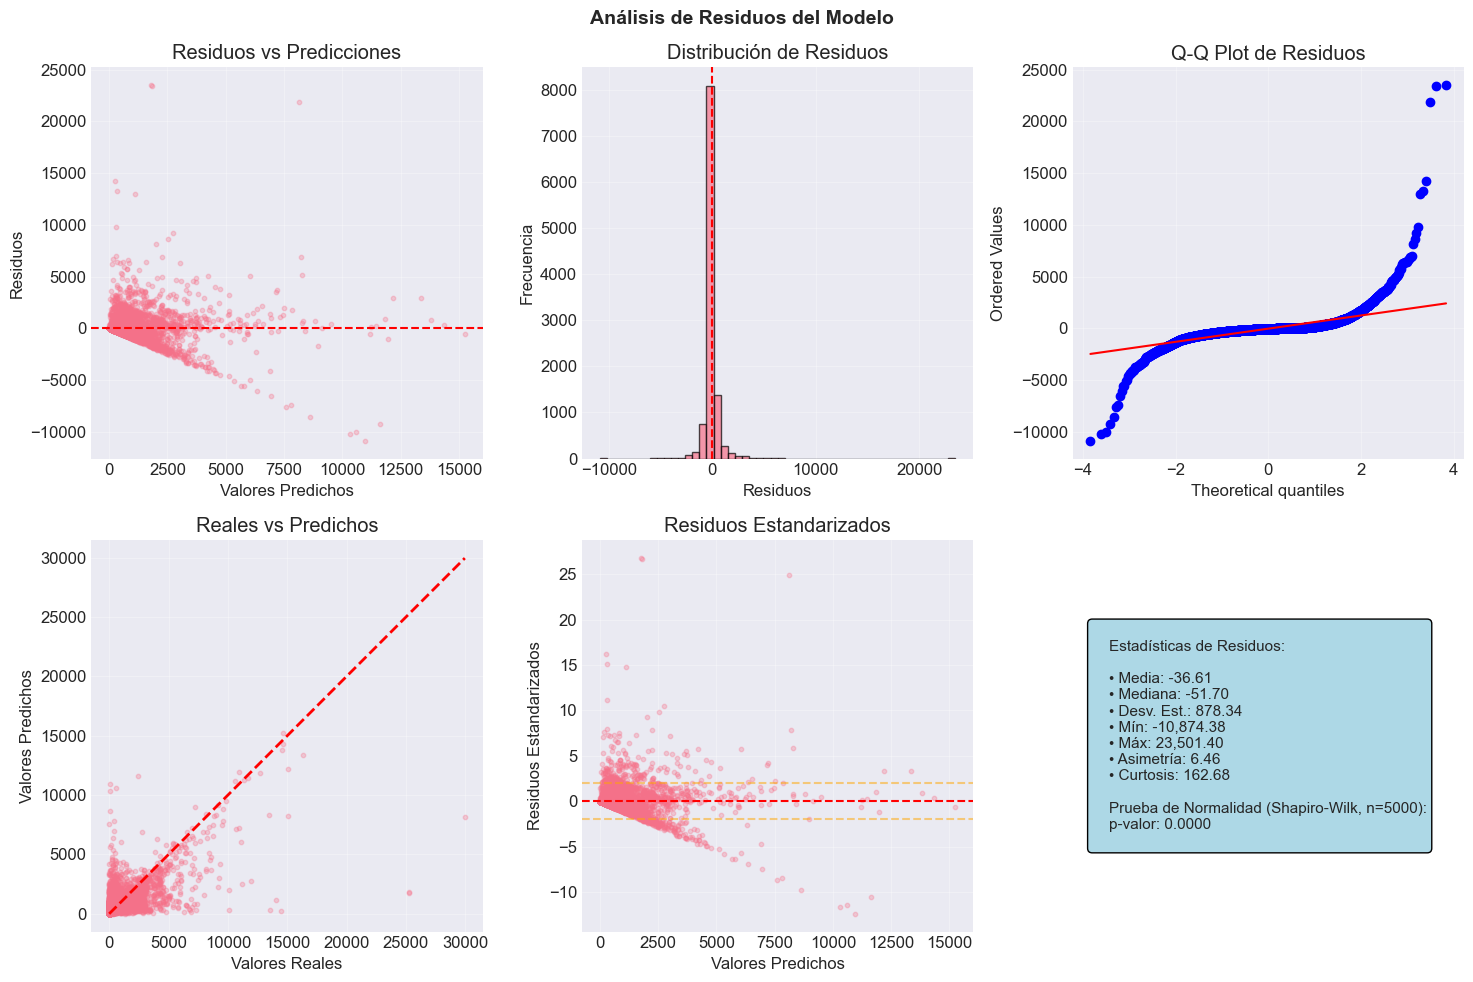


🧪 Análisis para modelo: LightGBM
   R² Test : 0.2121
   RMSE    : 1044.69
   MAE     : 421.19
   MAPE    : 3142.01%


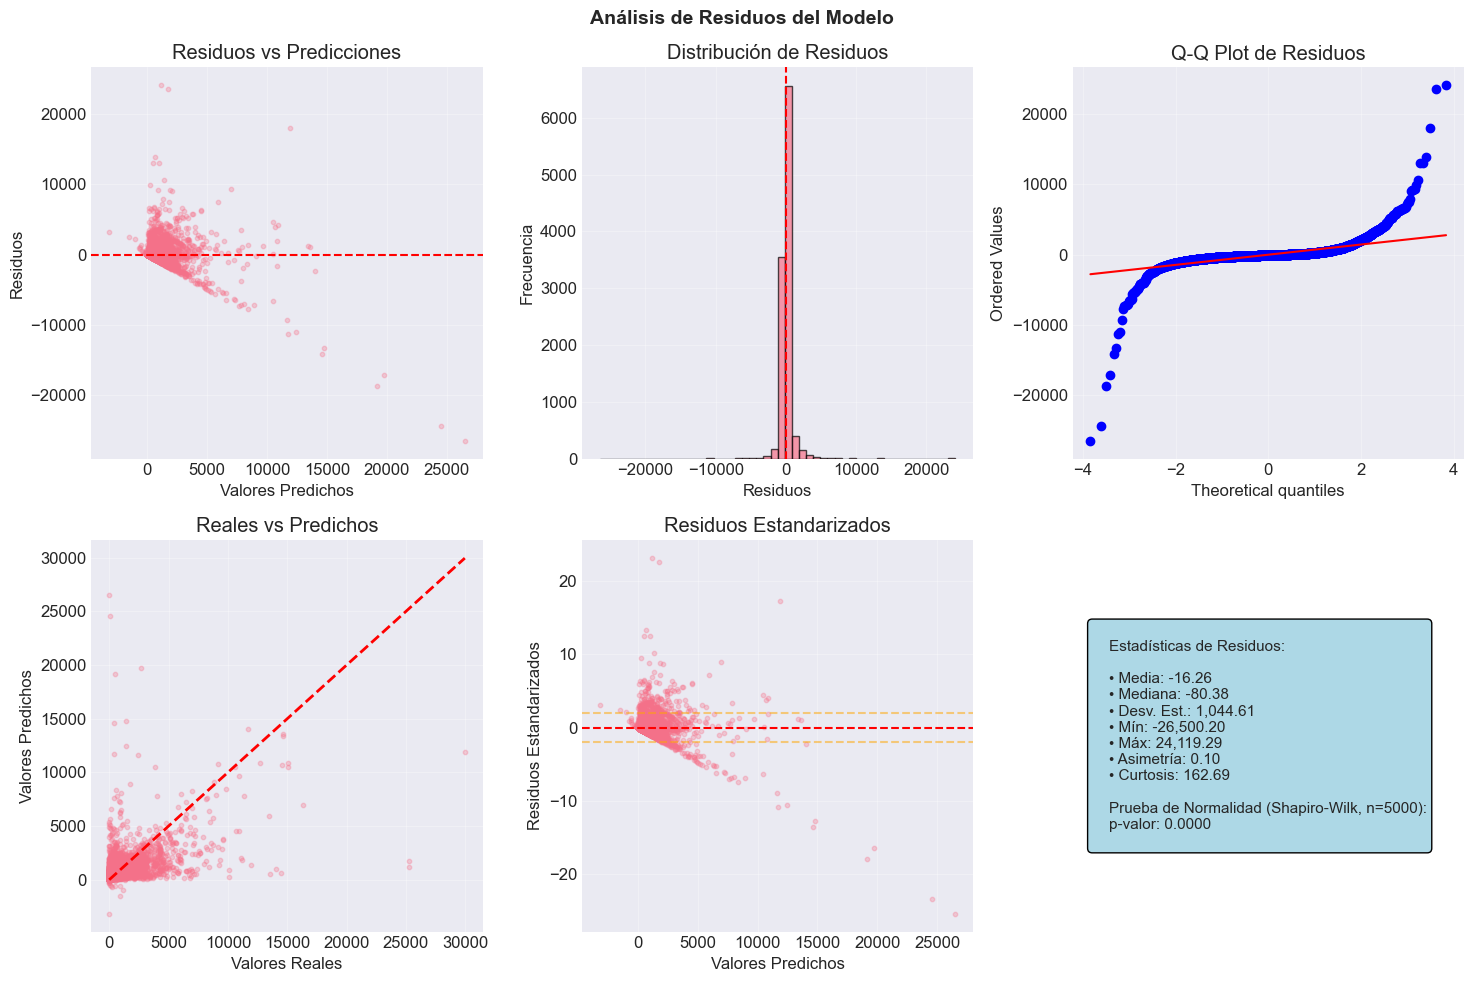

In [1850]:
for name in top2_model_names:
    print("\n" + "="*60)
    print(f"🧪 Análisis para modelo: {name}")
    
    model = models[name]  # el modelo ya está entrenado por tu loop anterior
    
    # Predicciones en test
    y_pred_test = model.predict(X_test)
    
    # Métricas
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    
    # MAPE robusto (evitar división por cero)
    y_test_safe = y_test.copy()
    mask_nonzero = y_test_safe != 0
    if mask_nonzero.any():
        mape_test = np.mean(
            np.abs((y_test_safe[mask_nonzero] - y_pred_test[mask_nonzero]) / y_test_safe[mask_nonzero])
        ) * 100
    else:
        mape_test = np.nan
    
    print(f"   R² Test : {r2_test:.4f}")
    print(f"   RMSE    : {rmse_test:.2f}")
    print(f"   MAE     : {mae_test:.2f}")
    print(f"   MAPE    : {mape_test:.2f}%")
    
    # 🔍 Análisis de residuos
    analyze_residuals(y_test, y_pred_test)

In [1854]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_confidence_intervals(model, X, confidence=0.95):
    """
    Calcula intervalos de confianza para las predicciones.
    Aproximación tipo ensemble: usa la variabilidad entre árboles.
    Solo funciona si el modelo tiene atributo estimators_ (RandomForest, ExtraTrees, etc.)
    """
    if not hasattr(model, 'estimators_'):
        # Sin prints para no ensuciar
        return None, None, None

    # 🔹 Asegurar que X sea un array, NO un DataFrame con nombres
    if isinstance(X, pd.DataFrame):
        X_input = X.values
    else:
        X_input = X

    # Predicción de cada árbol
    predictions = np.array([tree.predict(X_input) for tree in model.estimators_])
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)

    # z para el nivel de confianza
    z_score = stats.norm.ppf((1 + confidence) / 2)
    lower_bound = mean_pred - z_score * std_pred
    upper_bound = mean_pred + z_score * std_pred

    return mean_pred, lower_bound, upper_bound




🎯 Intervalos de confianza para: Extra Trees


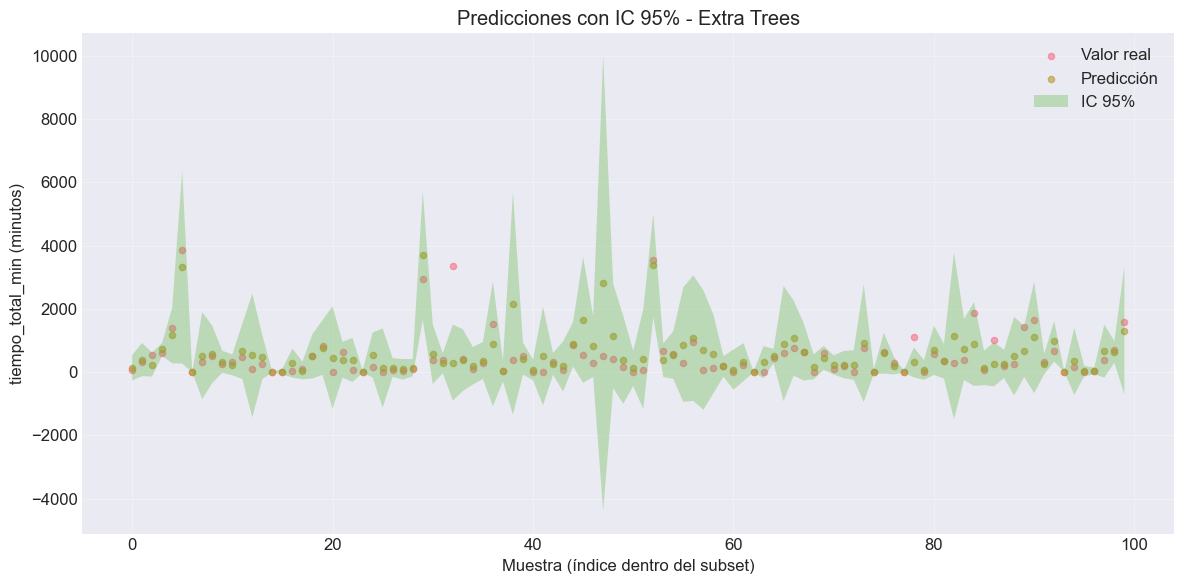

📊 Cobertura de los intervalos de confianza: 96.0%

🎯 Intervalos de confianza para: LightGBM


In [1855]:
# Tomar una muestra aleatoria del conjunto de prueba
sample_size = min(100, len(X_test))  # por si el test es pequeño
np.random.seed(42)
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

# Soportar X_test como DataFrame o array
if isinstance(X_test, pd.DataFrame):
    X_sample = X_test.iloc[sample_indices]
else:
    X_sample = X_test[sample_indices]

y_sample = y_test.iloc[sample_indices]

# =========================================================
# 3) Calcular y graficar IC para cada modelo del top 2
# =========================================================
for model_name in top2_model_names:
    print("\n" + "="*70)
    print(f"🎯 Intervalos de confianza para: {model_name}")
    
    model = models[model_name]  # modelo ya entrenado en tu loop previo
    
    mean_pred, lower_bound, upper_bound = calculate_confidence_intervals(
        model, X_sample  # usamos el mismo subset para comparar
    )
    
    # Si el modelo no tiene estimators_ (por ejemplo, CatBoost, LGBM, lineales), se salta
    if mean_pred is None:
        continue
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    indices = np.arange(sample_size)
    ax.scatter(indices, y_sample, label='Valor real', alpha=0.6, s=20)
    ax.scatter(indices, mean_pred, label='Predicción', alpha=0.6, s=20)
    ax.fill_between(indices, lower_bound, upper_bound,
                    alpha=0.3, label='IC 95%')
    
    ax.set_xlabel('Muestra (índice dentro del subset)')
    ax.set_ylabel('tiempo_total_min (minutos)')
    ax.set_title(f'Predicciones con IC 95% - {model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Cobertura del intervalo
    coverage = np.mean((y_sample >= lower_bound) & (y_sample <= upper_bound))
    print(f"📊 Cobertura de los intervalos de confianza: {coverage:.1%}")
